In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(6, 40949)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Gaps' in col and '18k' in col]

['Mean N gaps in g at 24hr in top 18k Gaps_24hr g band HealpixSlicer',
 'Mean N gaps in g at 3hr in top 18k Gaps_3hr g band HealpixSlicer',
 'Mean N gaps in g at 7hr in top 18k Gaps_7hr g band HealpixSlicer',
 'Mean N gaps in i at 24hr in top 18k Gaps_24hr i band HealpixSlicer',
 'Mean N gaps in i at 3hr in top 18k Gaps_3hr i band HealpixSlicer',
 'Mean N gaps in i at 7hr in top 18k Gaps_7hr i band HealpixSlicer',
 'Mean N gaps in r at 24hr in top 18k Gaps_24hr r band HealpixSlicer',
 'Mean N gaps in r at 3hr in top 18k Gaps_3hr r band HealpixSlicer',
 'Mean N gaps in r at 7hr in top 18k Gaps_7hr r band HealpixSlicer',
 'Mean N gaps in u at 24hr in top 18k Gaps_24hr u band HealpixSlicer',
 'Mean N gaps in u at 3hr in top 18k Gaps_3hr u band HealpixSlicer',
 'Mean N gaps in u at 7hr in top 18k Gaps_7hr u band HealpixSlicer',
 'Mean N gaps in y at 24hr in top 18k Gaps_24hr y band HealpixSlicer',
 'Mean N gaps in y at 3hr in top 18k Gaps_3hr y band HealpixSlicer',
 'Mean N gaps in y at 7h

In [10]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             #'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
             #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [11]:
#data['KNe single model'] # data['KNe ZTF simple']

In [12]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [13]:
mag_data

g          i          r          u          y  \
baseline_v3.2_10yrs  26.678103  26.295888  26.807880  25.622696  24.766647   
tight_t1_v3.2_10yrs  26.699064  26.303733  26.810073  25.630748  24.762569   
tight_t2_v3.2_10yrs  26.533872  26.309327  26.750578  25.552551  24.819537   
tight_t3_v3.2_10yrs  26.693504  26.282214  26.812519  25.618280  24.747477   
tight_t4_v3.2_10yrs  26.705214  26.283979  26.811475  25.620453  24.747804   
tight_t5_v3.2_10yrs  26.690260  26.284688  26.792726  25.619603  24.745952   

                             z  
baseline_v3.2_10yrs  25.586860  
tight_t1_v3.2_10yrs  25.567733  
tight_t2_v3.2_10yrs  25.606083  
tight_t3_v3.2_10yrs  25.576091  
tight_t4_v3.2_10yrs  25.576295  
tight_t5_v3.2_10yrs  25.583471

In [14]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS  N SN ECDFS    N SN EDFS  N SN ELAISS1  \
baseline_v3.2_10yrs   971.481238  868.593513  1528.851192    844.740564   
tight_t1_v3.2_10yrs   957.205335  863.514531  1540.330928    856.501431   
tight_t2_v3.2_10yrs   996.579974  854.847233  1546.926946    893.220476   
tight_t3_v3.2_10yrs   993.435098  877.090580  1565.033255    888.394946   
tight_t4_v3.2_10yrs   969.048530  898.554582  1584.497835    854.282683   
tight_t5_v3.2_10yrs  1010.000192  896.907586  1601.346128    892.114950   

                     N SN XMM_LSS  zlim COSMOS  zlim ECDFS  zlim EDFS  \
baseline_v3.2_10yrs    840.405268     0.510969    0.550142   0.486932   
tight_t1_v3.2_10yrs    839.720211     0.515683    0.538171   0.488698   
tight_t2_v3.2_10yrs    822.070479     0.507764    0.536699   0.487243   
tight_t3_v3.2_10yrs    879.648590     0.509971    0.551067   0.487668   
tight_t4_v3.2_10yrs    891.977153     0.512193    0.546192   0.489596   
tight_t5_v3.2_10yrs    868.835211     0.503061    0.549498   0.488981   

                     zlim ELAISS1  zlim XMM_LSS  ...  Kne EDFS  Kne ELAISS1  \
baseline_v3.2_10yrs      0.516296      0.502590  ...     428.0        341.0   
tight_t1_v3.2_10yrs      0.513874      0.505236  ...     463.0        332.0   
tight_t2_v3.2_10yrs      0.525415      0.505617  ...     434.0        351.0   
tight_t3_v3.2_10yrs      0.515601      0.501696  ...     452.0        363.0   
tight_t4_v3.2_10yrs      0.518273      0.500531  ...     474.0        334.0   
tight_t5_v3.2_10yrs      0.515487      0.507944  ...     464.0        357.0   

                     Kne WFD  Kne XMM_LSS  N COSMOS  N ECDFS  N EDFS  \
baseline_v3.2_10yrs    336.0        321.0   19496.5  10806.5  6800.0   
tight_t1_v3.2_10yrs    307.0        327.0   19468.0  10813.5  6779.0   
tight_t2_v3.2_10yrs    287.0        338.0   19528.0  10785.5  6783.0   
tight_t3_v3.2_10yrs    312.0        343.0   19533.5  10830.0  6782.0   
tight_t4_v3.2_10yrs    320.0        338.0   19618.5  10859.5  6782.0   
tight_t5_v3.2_10yrs    313.0        335.0   19672.5  10836.5  6787.0   

                     N ELAISS1  N WFD  N XMM_LSS  
baseline_v3.2_10yrs    10295.0  861.0    10714.0  
tight_t1_v3.2_10yrs    10339.0  850.0    10670.0  
tight_t2_v3.2_10yrs    10355.0  857.0    10704.0  
tight_t3_v3.2_10yrs    10352.0  861.0    10797.0  
tight_t4_v3.2_10yrs    10348.0  850.0    10765.0  
tight_t5_v3.2_10yrs    10389.0  860.0    10619.0  

[6 rows x 22 columns]

In [15]:
gaps_data

gaps u 3  gaps u 7  gaps u 24  gaps g 3  gaps g 7  \
baseline_v3.2_10yrs  0.140020  0.100247   3.084814  0.605912  0.540215   
tight_t1_v3.2_10yrs  0.138155  0.073390   3.005082  0.391477  0.294680   
tight_t2_v3.2_10yrs  0.130601  0.042663   2.258218  0.539936  0.462862   
tight_t3_v3.2_10yrs  0.145941  0.080384   2.977246  0.668672  0.625915   
tight_t4_v3.2_10yrs  0.113349  0.092694   2.990395  0.607078  0.594069   
tight_t5_v3.2_10yrs  0.155593  0.064158   3.096377  0.135683  0.079778   

                     gaps g 24  gaps r 3  gaps r 7  gaps r 24  gaps i 3  \
baseline_v3.2_10yrs   3.727001  1.198583  0.843055  20.776752  2.040891   
tight_t1_v3.2_10yrs   3.856064  1.453630  0.907679  21.088917  2.240780   
tight_t2_v3.2_10yrs   3.084907  1.667459  1.290623  18.371754  1.739404   
tight_t3_v3.2_10yrs   3.963538  1.067142  0.737586  20.570290  1.482352   
tight_t4_v3.2_10yrs   4.167716  1.108966  0.782487  20.954073  1.458013   
tight_t5_v3.2_10yrs   4.491724  2.163240  1.472001  20.451438  1.567912   

                     gaps i 7  gaps i 24  gaps z 3  gaps z 7  gaps z 24  \
baseline_v3.2_10yrs  1.196717  19.389239  1.162540  0.734229  16.713013   
tight_t1_v3.2_10yrs  1.484683  19.264932  1.212944  0.659766  16.926377   
tight_t2_v3.2_10yrs  1.043503  20.027976  0.891500  0.625589  15.237283   
tight_t3_v3.2_10yrs  0.962699  19.096937  1.675572  1.024712  15.022661   
tight_t4_v3.2_10yrs  0.998415  19.314683  1.700518  0.958456  15.327412   
tight_t5_v3.2_10yrs  1.037814  19.903763  1.094559  0.703129  15.869026   

                     gaps y 3  gaps y 7  gaps y 24  
baseline_v3.2_10yrs  1.363501  0.541941  13.219471  
tight_t1_v3.2_10yrs  1.196764  0.451718  13.328624  
tight_t2_v3.2_10yrs  1.400056  0.475311  14.494008  
tight_t3_v3.2_10yrs  1.228097  0.469483  12.174290  
tight_t4_v3.2_10yrs  1.359957  0.532009  12.461696  
tight_t5_v3.2_10yrs  1.149858  0.432881  13.350212

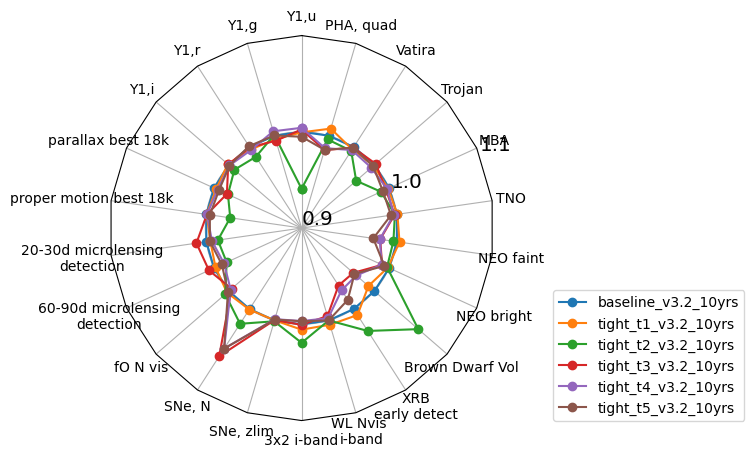

In [20]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

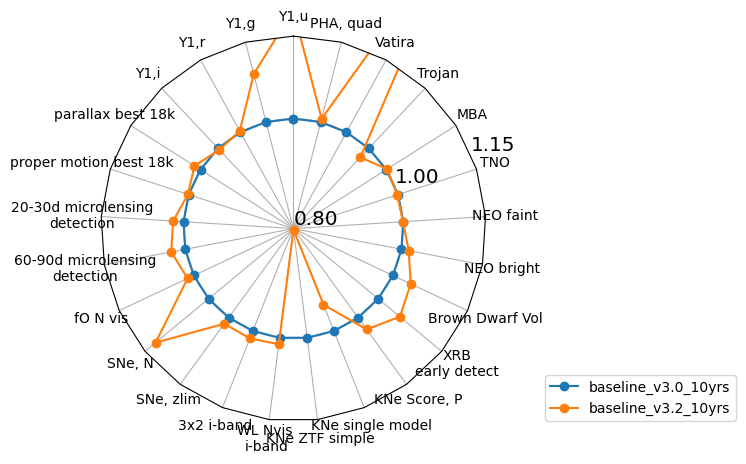

In [15]:
runs = ['baseline_v3.0_10yrs', 'baseline_v3.2_10yrs'] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')


fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.15], bbox_to_anchor=(1.65, 0))

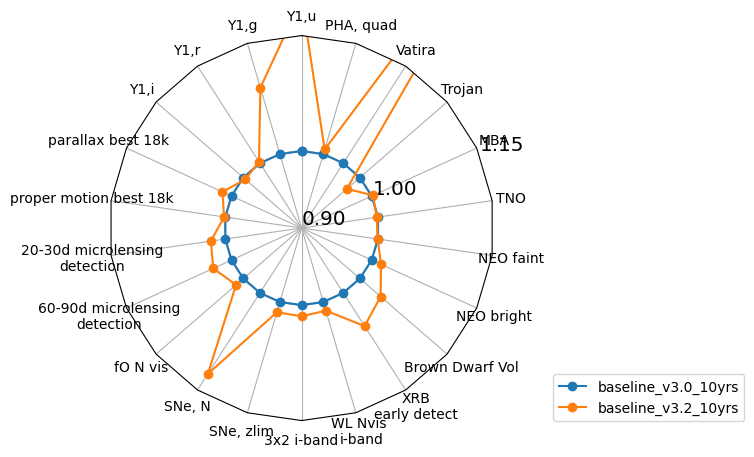

In [16]:
runs = ['baseline_v3.0_10yrs', 'baseline_v3.2_10yrs'] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')

for col in ndata.columns:
    if 'KNe' in col:
        ndata = ndata.drop(labels=col, axis=1)

fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.15], bbox_to_anchor=(1.65, 0))

In [17]:
ndata.columns

Index(['Y1,u', 'Y1,g', 'Y1,r', 'Y1,i', 'parallax best 18k',
       'proper motion best 18k', '20-30d microlensing\ndetection',
       '60-90d microlensing\ndetection', 'fO N vis', 'SNe, N', 'SNe, zlim',
       '3x2 i-band', 'WL Nvis \ni-band', 'XRB\nearly detect',
       'Brown Dwarf Vol', 'NEO bright', 'NEO faint', 'TNO', 'MBA', 'Trojan',
       'Vatira', 'PHA, quad'],
      dtype='object')

In [18]:
data['Vatira']

baseline_v2.0_10yrs                0.0039
baseline_v2.1_10yrs                0.0017
baseline_v2.2_10yrs                0.0008
baseline_v3.0_10yrs                0.0376
baseline_v3.2_10yrs                0.4628
ddf_half_v3.2_10yrs                0.4673
ddf_loaded_half_fl01_v3.2_10yrs    0.4649
ddf_loaded_half_fl02_v3.2_10yrs    0.4589
ddf_loaded_half_fl04_v3.2_10yrs    0.4601
ddf_loaded_half_fl08_v3.2_10yrs    0.4620
ddf_loaded_half_fl15_v3.2_10yrs    0.4598
ddf_loaded_uy_fl01_v3.2_10yrs      0.4634
ddf_loaded_uy_fl02_v3.2_10yrs      0.4645
ddf_loaded_uy_fl04_v3.2_10yrs      0.4632
ddf_loaded_uy_fl08_v3.2_10yrs      0.4660
ddf_loaded_uy_fl15_v3.2_10yrs      0.4616
ddf_loaded_uzy_fl01_v3.2_10yrs     0.4598
ddf_loaded_uzy_fl02_v3.2_10yrs     0.4657
ddf_loaded_uzy_fl04_v3.2_10yrs     0.4604
ddf_loaded_uzy_fl08_v3.2_10yrs     0.4645
ddf_loaded_uzy_fl15_v3.2_10yrs     0.4562
filter_uy_v3.2_10yrs               0.4628
filter_uz_v3.2_10yrs               0.4597
filter_uzy_v3.2_10yrs             

In [19]:
ddf_data

N SN COSMOS   N SN ECDFS    N SN EDFS  \
baseline_v2.0_10yrs               638.253284   586.826209   974.231557   
baseline_v2.1_10yrs               548.479625   545.669910   875.981802   
baseline_v2.2_10yrs               708.239238   685.202422  1067.553931   
baseline_v3.0_10yrs               955.159293   799.584601  1266.961769   
baseline_v3.2_10yrs               971.481238   868.593513  1528.851192   
ddf_half_v3.2_10yrs              1166.880059  1129.227216  1720.470859   
ddf_loaded_half_fl01_v3.2_10yrs  1027.370260   928.280307  1480.708095   
ddf_loaded_half_fl02_v3.2_10yrs  1133.325290  1065.510068  1629.174985   
ddf_loaded_half_fl04_v3.2_10yrs  1174.934827  1156.404721  1729.738107   
ddf_loaded_half_fl08_v3.2_10yrs  1198.193790  1194.487851  1782.466065   
ddf_loaded_half_fl15_v3.2_10yrs  1277.173051  1211.724744  1812.208009   
ddf_loaded_uy_fl01_v3.2_10yrs     857.379633   706.813786  1268.470459   
ddf_loaded_uy_fl02_v3.2_10yrs     992.720699   914.078093  1523.082694   
ddf_loaded_uy_fl04_v3.2_10yrs    1077.527601  1047.846424  1631.013584   
ddf_loaded_uy_fl08_v3.2_10yrs    1163.416261  1113.221455  1692.126968   
ddf_loaded_uy_fl15_v3.2_10yrs    1201.092034  1167.865557  1761.117457   
ddf_loaded_uzy_fl01_v3.2_10yrs    859.471823   734.550770  1232.464265   
ddf_loaded_uzy_fl02_v3.2_10yrs    980.423642   936.398009  1478.748433   
ddf_loaded_uzy_fl04_v3.2_10yrs   1104.006281  1059.583509  1683.163078   
ddf_loaded_uzy_fl08_v3.2_10yrs   1163.600118  1130.550249  1735.787310   
ddf_loaded_uzy_fl15_v3.2_10yrs   1200.984999  1154.566214  1796.542082   
filter_uy_v3.2_10yrs              971.481238   868.593513  1528.851192   
filter_uz_v3.2_10yrs              910.523965   827.904127  1419.493359   
filter_uzy_v3.2_10yrs            1021.279625   957.001932  1620.836596   
more_long_v3.2_10yrs              964.067639   848.184107  1478.167236   
no_long_v3.2_10yrs                979.067169   845.163011  1519.301358   
noroll_v3.2_10yrs                1050.425362  1007.677308  1587.404524   
retro_baseline_v2.0_10yrs         633.216869   678.859654  1098.712998   
weather_cloudso0v3.2_10yrs        971.481238   868.593513  1528.851192   
weather_cloudso10v3.2_10yrs       915.437009   792.371507  1339.484181   
weather_cloudso12v3.2_10yrs       919.724914   800.319285  1408.837954   
weather_cloudso14v3.2_10yrs       906.029032   745.630159  1352.836413   
weather_cloudso16v3.2_10yrs       918.713736   838.506381  1339.605101   
weather_cloudso18v3.2_10yrs       935.778502   782.702897  1252.108674   
weather_cloudso1v3.2_10yrs       1001.516642   893.046247  1509.373570   
weather_cloudso20v3.2_10yrs       929.356999   819.961607  1267.849236   
weather_cloudso2v3.2_10yrs        983.765904   888.313646  1493.988770   
weather_cloudso30v3.2_10yrs       918.974166   767.300533  1235.419923   
weather_cloudso31v3.2_10yrs       923.929027   758.751066  1331.837696   
weather_cloudso35v3.2_10yrs       905.093131   819.963739  1318.210628   
weather_cloudso36v3.2_10yrs       952.812961   782.900660  1273.781076   
weather_cloudso4v3.2_10yrs        941.690097   873.951250  1495.992237   
weather_cloudso6v3.2_10yrs        993.185144   851.208253  1534.867682   
weather_cloudso8v3.2_10yrs        957.641748   786.334094  1440.354745   

                                 N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
baseline_v2.0_10yrs                684.401547    611.229060     0.503926   
baseline_v2.1_10yrs                636.634918    520.071105     0.496150   
baseline_v2.2_10yrs                674.561648    611.247120     0.493897   
baseline_v3.0_10yrs                688.808879    726.491723     0.503734   
baseline_v3.2_10yrs                844.740564    840.405268     0.510969   
ddf_half_v3.2_10yrs               1109.587040   1163.958806     0.512223   
ddf_loaded_half_fl01_v3.2_10yrs    962.377007    915.935273     0.479699   
ddf_loaded_half_fl02_v3.2_10yrs   1093.154602   1068.557854     0.494822   
ddf_loaded_half_fl

In [20]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



Y1,u      Y1,g      Y1,r      Y1,i  \
retro_baseline_v2.0_10yrs  0.893276  0.949104  0.960964  0.958616   
baseline_v2.0_10yrs        0.955776  0.981594  0.994441  0.997035   
baseline_v2.1_10yrs        0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs        0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs        0.813058  0.901174  0.993823  0.999135   
baseline_v3.2_10yrs        0.973633  0.982335  0.996170  0.995800   

                           parallax best 18k  proper motion best 18k  \
retro_baseline_v2.0_10yrs           0.804328                0.176701   
baseline_v2.0_10yrs                 0.791058                0.184088   
baseline_v2.1_10yrs                 0.806910                0.188258   
baseline_v2.2_10yrs                 0.792958                0.186345   
baseline_v3.0_10yrs                 0.792666                0.185683   
baseline_v3.2_10yrs                 0.782518                0.185369   

                           20-30d microlensing\ndetection  \
retro_baseline_v2.0_10yrs                          0.0883   
baseline_v2.0_10yrs                                0.3116   
baseline_v2.1_10yrs                                0.3111   
baseline_v2.2_10yrs                                0.3212   
baseline_v3.0_10yrs                                0.3239   
baseline_v3.2_10yrs                                0.3430   

                           60-90d microlensing\ndetection  fO N vis  \
retro_baseline_v2.0_10yrs                          0.1533     848.0   
baseline_v2.0_10yrs                                0.4284     839.0   
baseline_v2.1_10yrs                                0.4312     838.0   
baseline_v2.2_10yrs                                0.4462     830.0   
baseline_v3.0_10yrs                                0.4559     795.0   
baseline_v3.2_10yrs                                0.4820     805.0   

                                  SNe, N  ...  KNe Score, P  \
retro_baseline_v2.0_10yrs   97124.012102  ...    202.730488   
baseline_v2.0_10yrs         99302.532220  ...    263.696398   
baseline_v2.1_10yrs         99294.339899  ...    243.713720   
baseline_v2.2_10yrs        112802.099640  ...    242.377184   
baseline_v3.0_10yrs        109475.798536  ...    228.428876   
baseline_v3.2_10yrs        123176.659086  ...    234.485632   

                           XRB\nearly detect  Brown Dwarf Vol  NEO bright  \
retro_baseline_v2.0_10yrs              720.0    179640.718155      0.9048   
baseline_v2.0_10yrs                   1879.0    168086.074111      0.9294   
baseline_v2.1_10yrs                   1918.0    163815.013503      0.9286   
baseline_v2.2_10yrs                   1920.0    172453.127988      0.9304   
baseline_v3.0_10yrs                   1950.0    168032.537231      0.9326   
baseline_v3.2_10yrs                   2050.0    174053.517478      0.9460   

                           NEO faint       TNO       MBA    Trojan  Vatira  \
retro_baseline_v2.0_10yrs   0.623933  0.705953  0.943433  0.667158  0.0000   
baseline_v2.0_10yrs         0.642021  0.719635  0.918999  0.588087  0.0039   
baseline_v2.1_10yrs         0.647553  0.723197  0.927567  0.608979  0.0017   
baseline_v2.2_10yrs         0.657462  0.723899  0.933507  0.615249  0.0008   
baseline_v3.0_10yrs         0.642155  0.722293  0.924156  0.611053  0.0376   
baseline_v3.2_10yrs         0.641896  0.720793  0.926248  0.588856  0.4628   

                           PHA, quad  
retro_baseline_v2.0_10yrs   0.847880  
baseline_v2.0_10yrs         0.859238  
baseline_v2.1_10yrs         0.865438  
baseline_v2.2_10yrs         0.858538  
baseline_v3.0_10yrs         0.887938  
baseline_v3.2_10yrs         0.893584  

[6 rows x 25 columns]

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


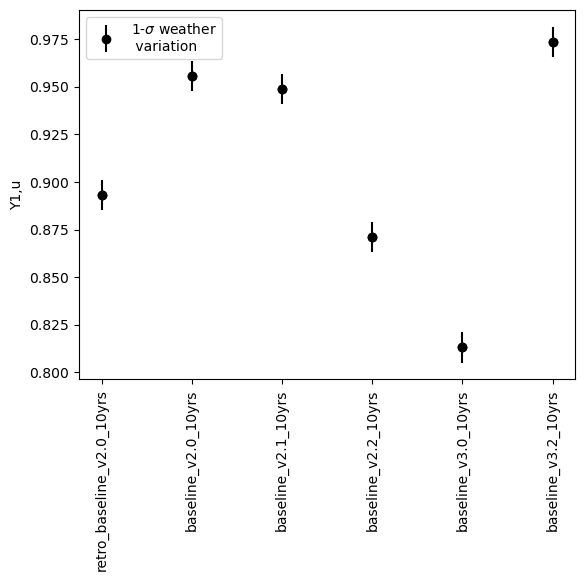

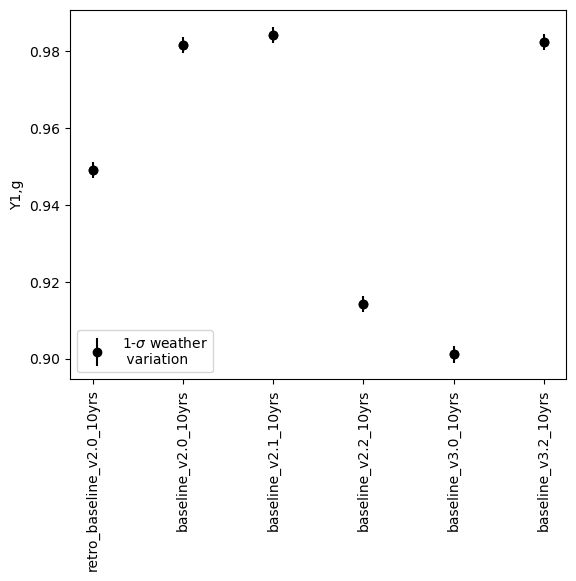

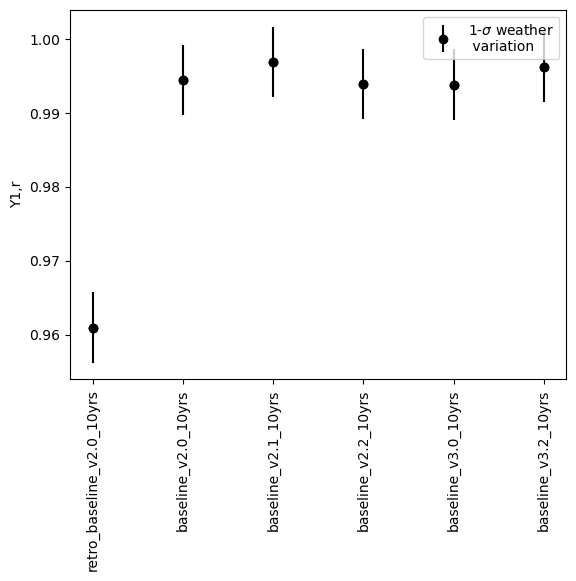

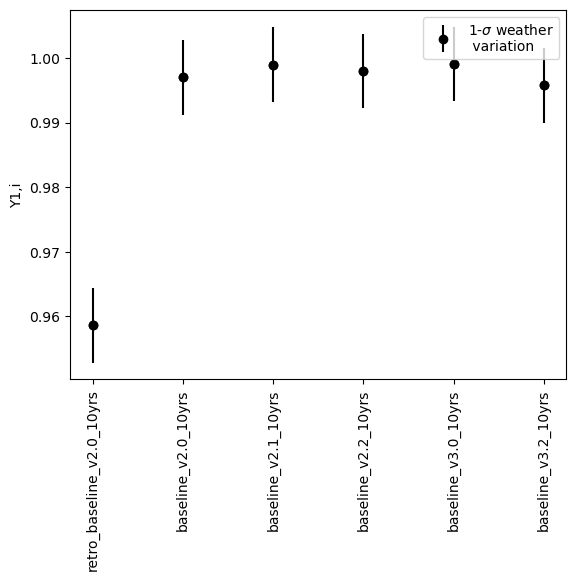

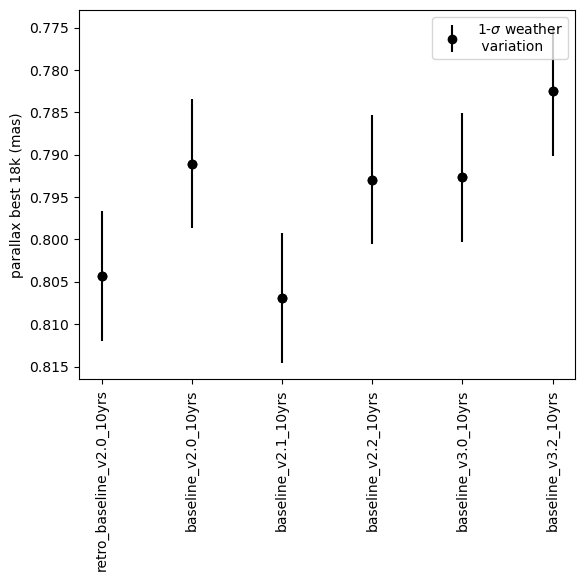

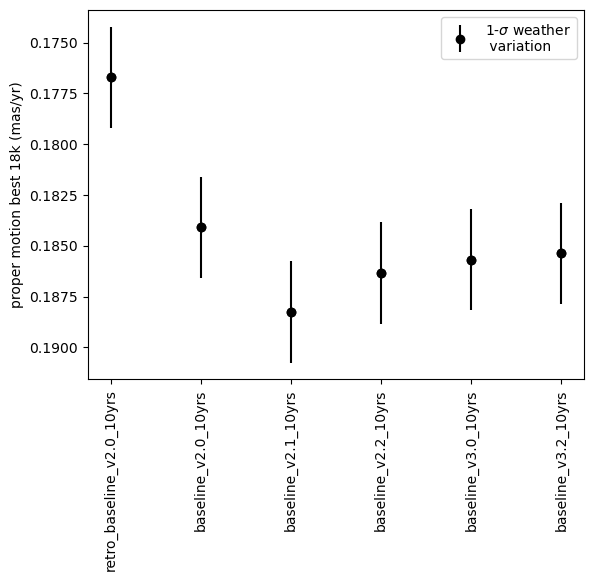

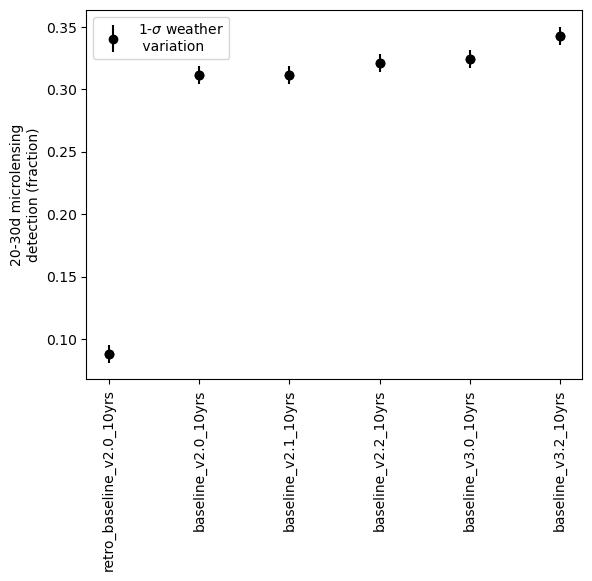

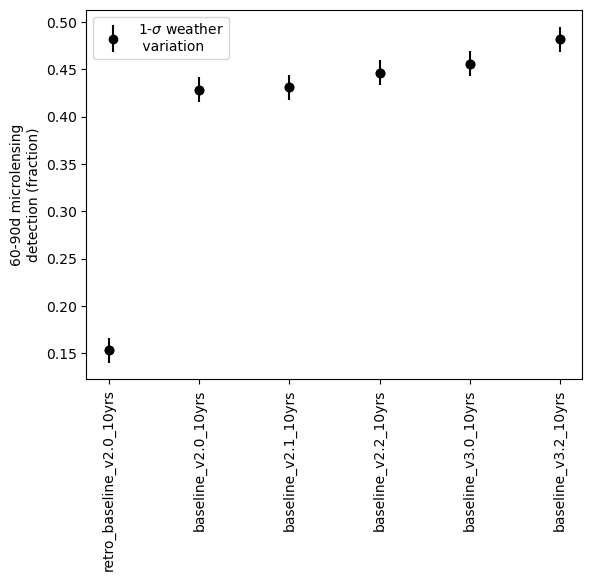

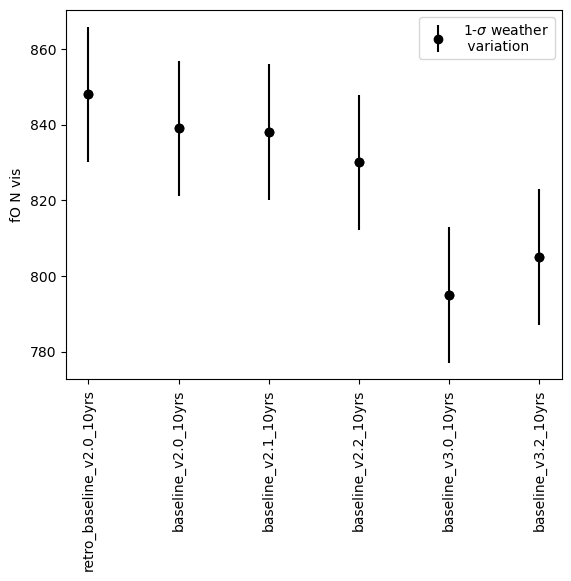

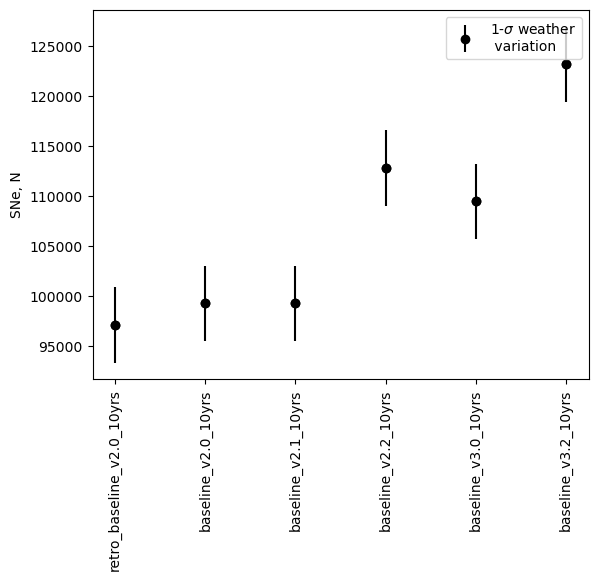

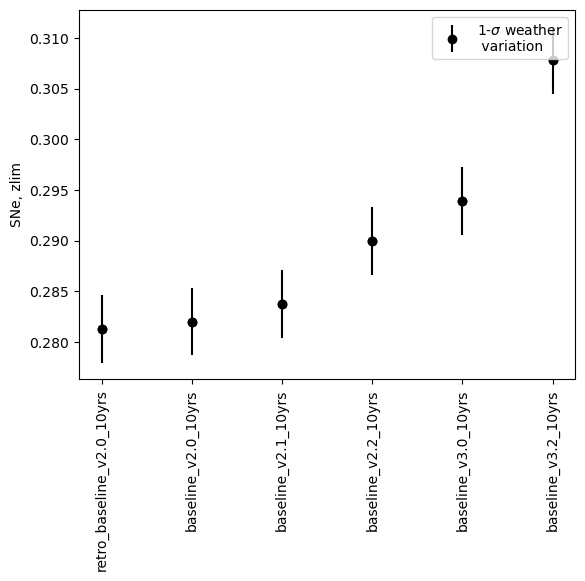

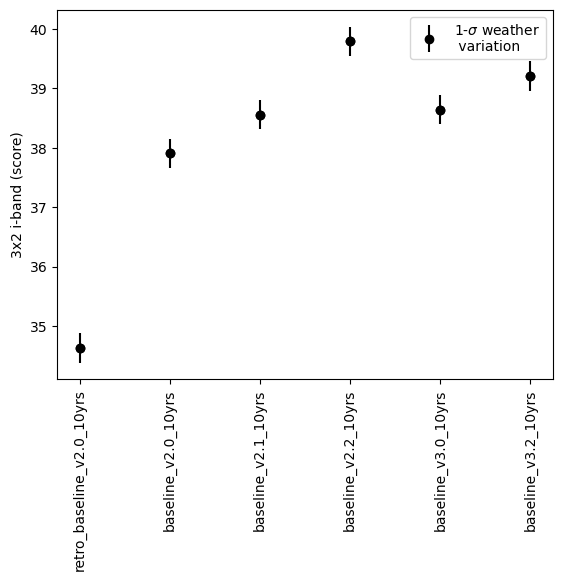

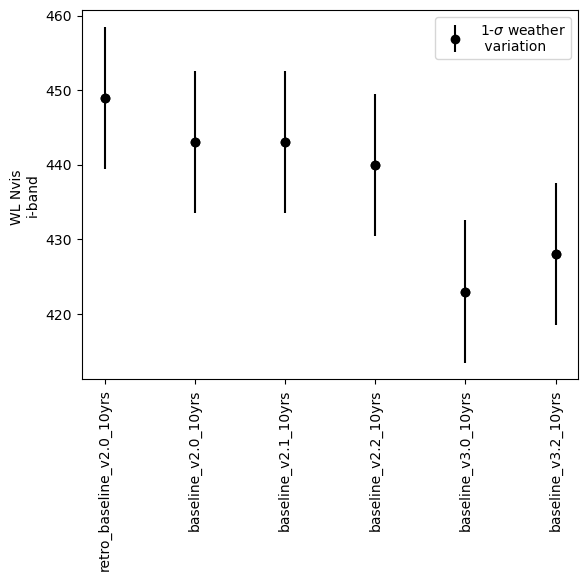

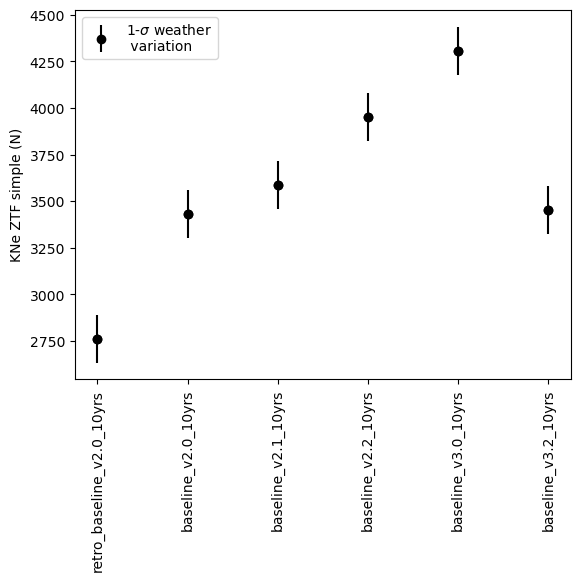

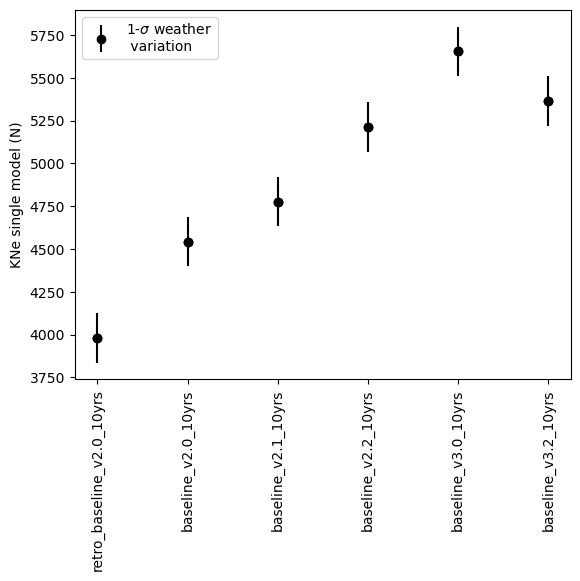

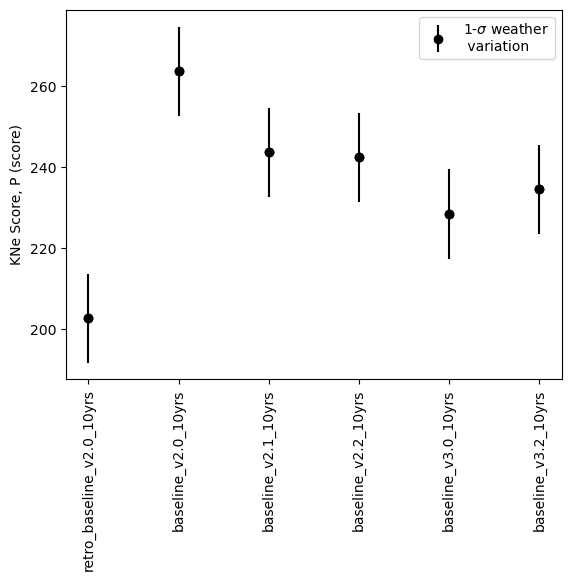

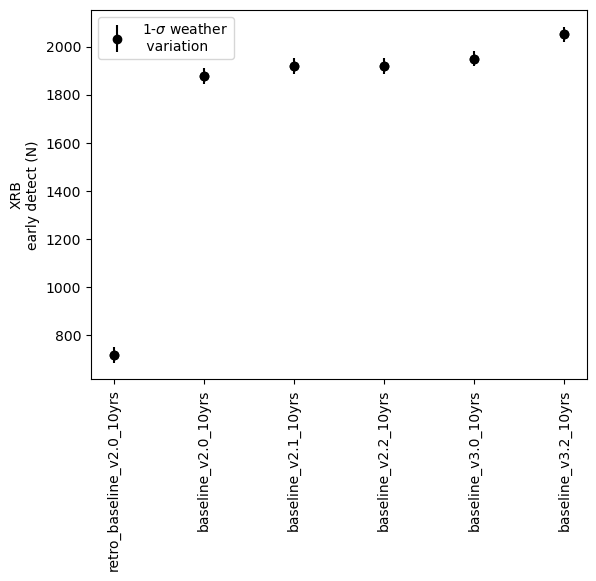

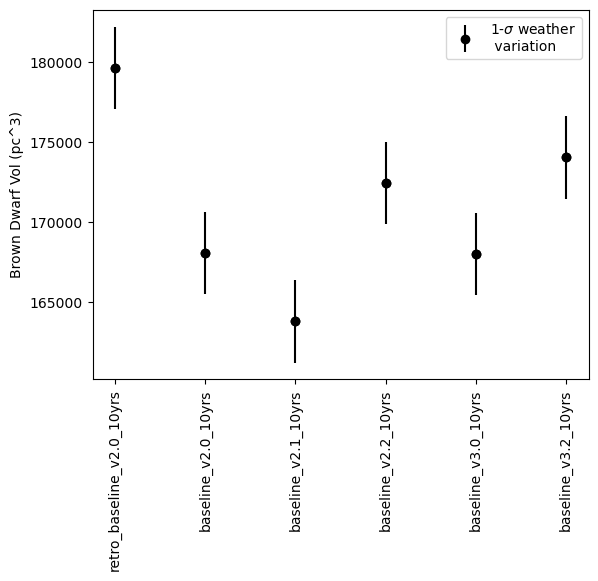

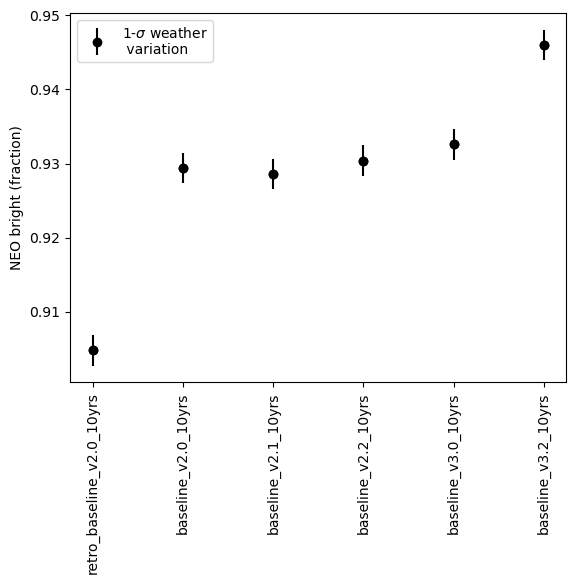

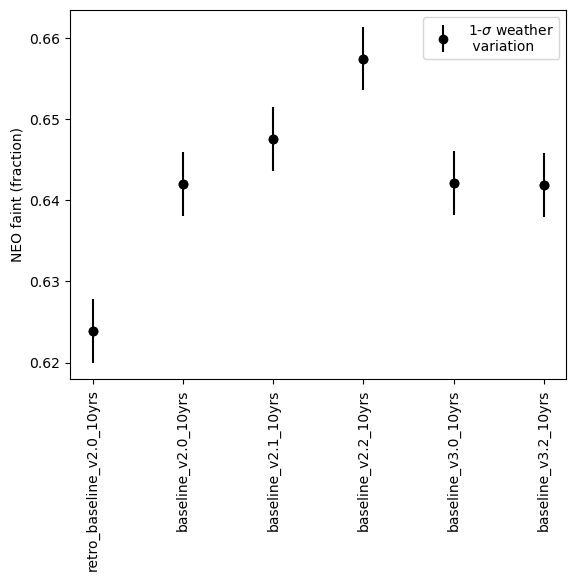

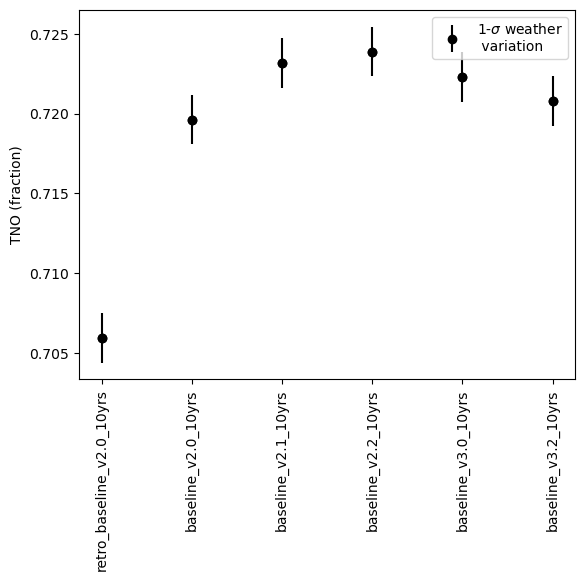

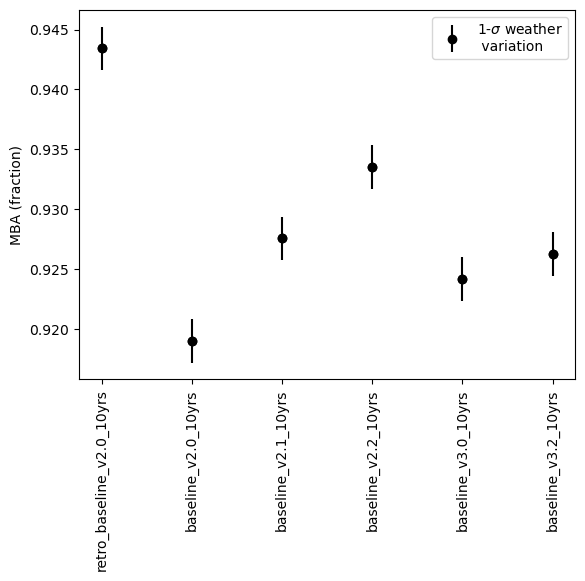

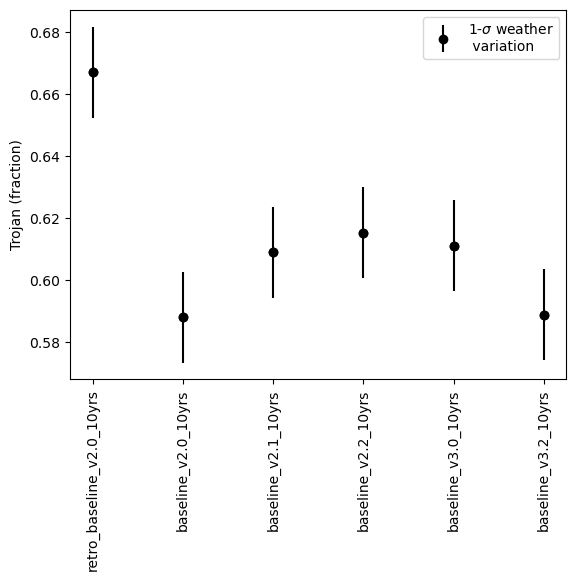

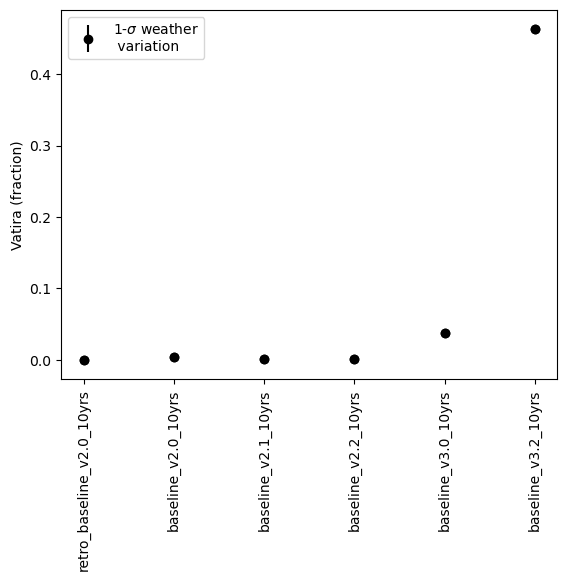

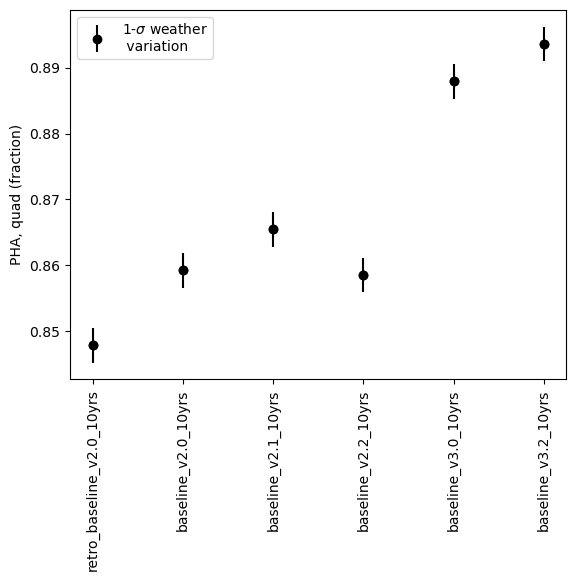

In [21]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/1073381334.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',


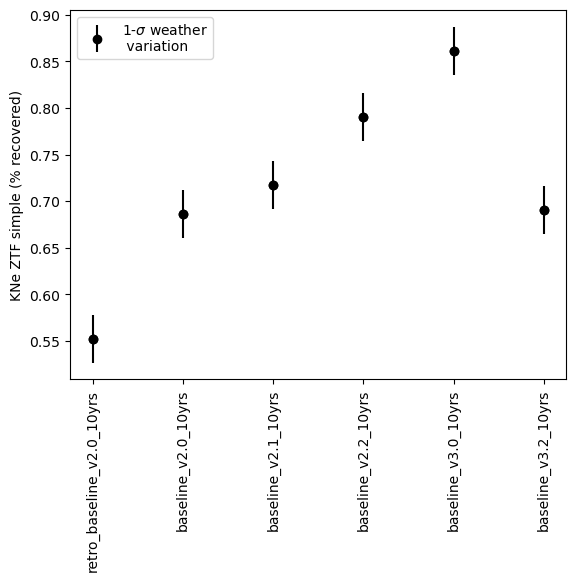

In [22]:
#col = data.columns[0]
n=500000/100
for col in ['KNe ZTF simple']:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col]/n, 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col]/n, yerr=std_dict[col]/n, fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (% recovered)'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


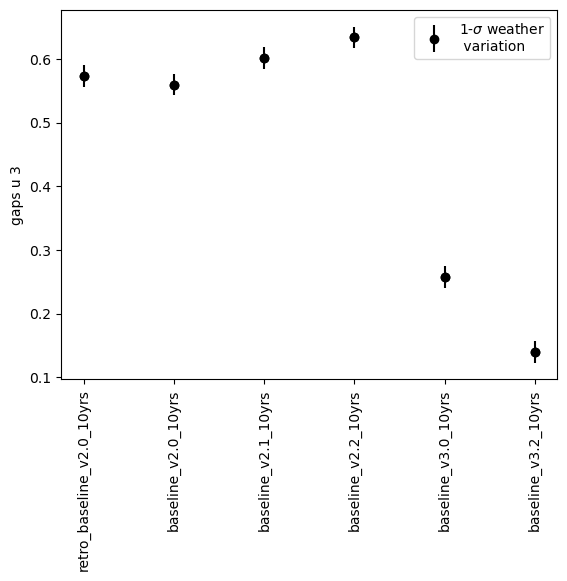

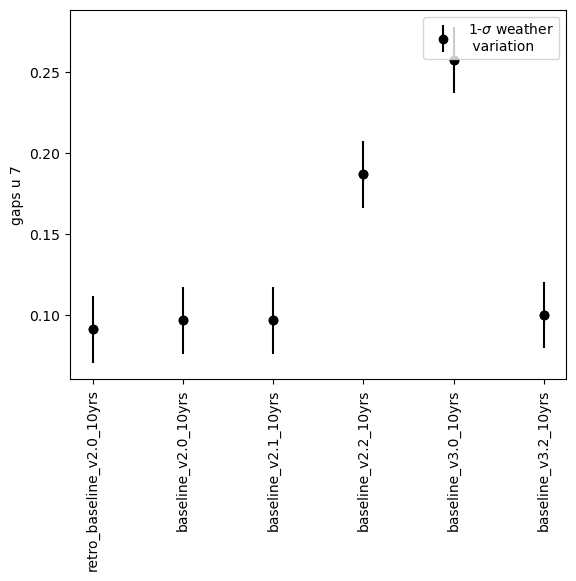

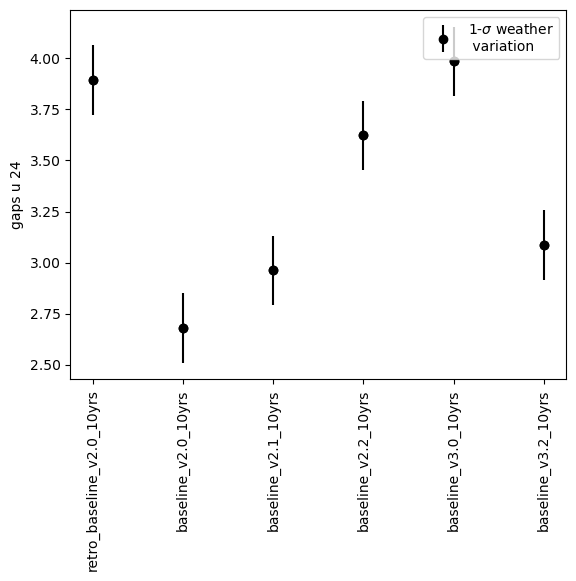

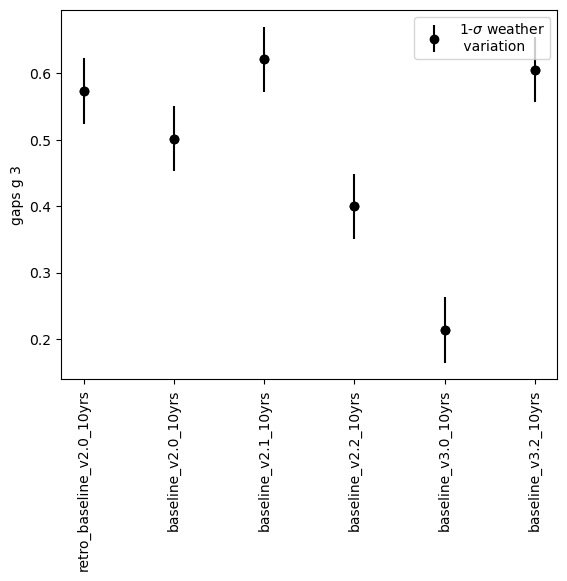

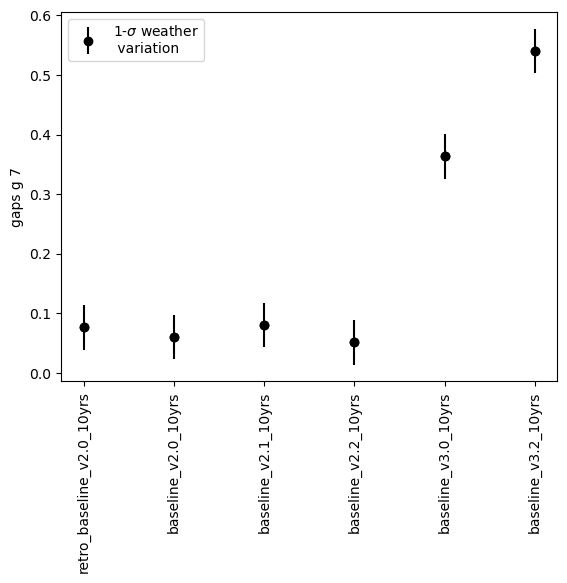

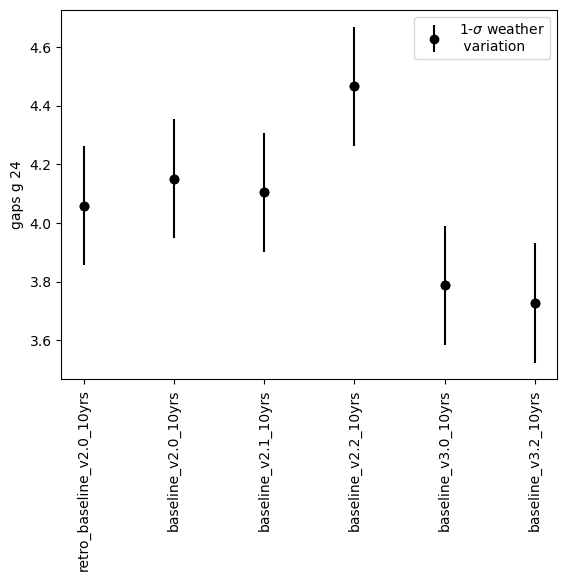

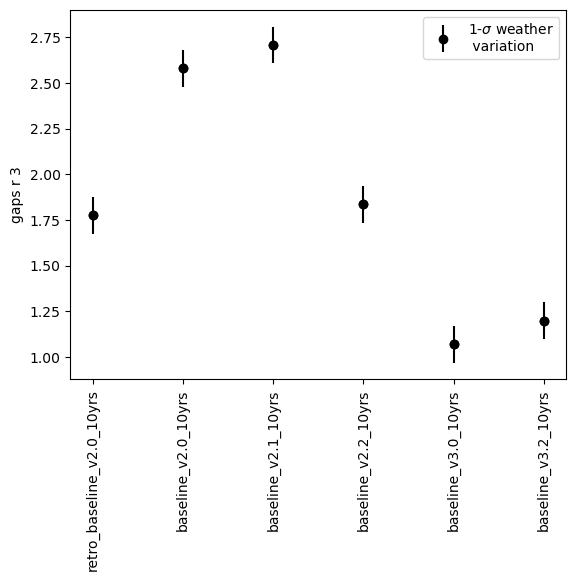

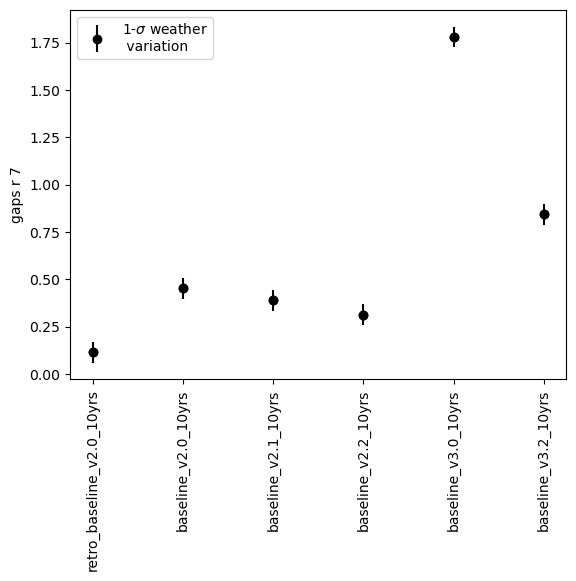

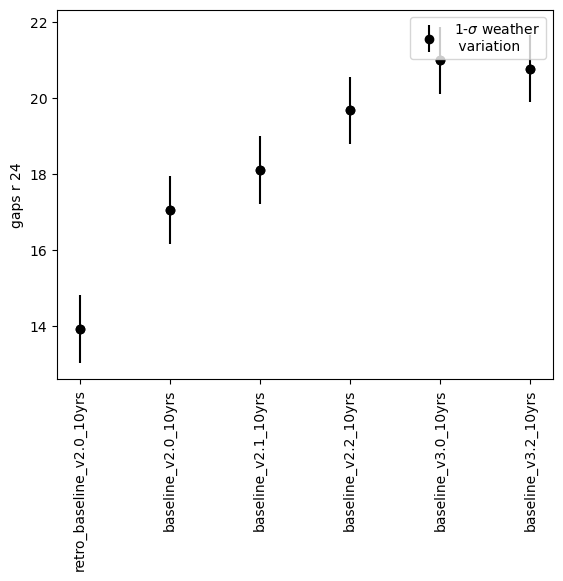

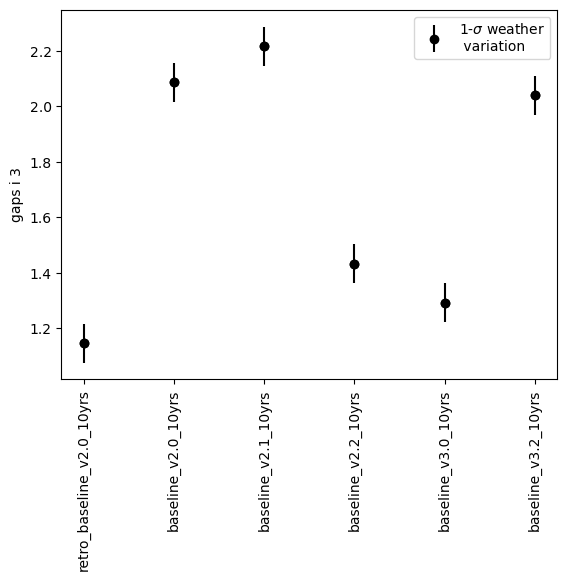

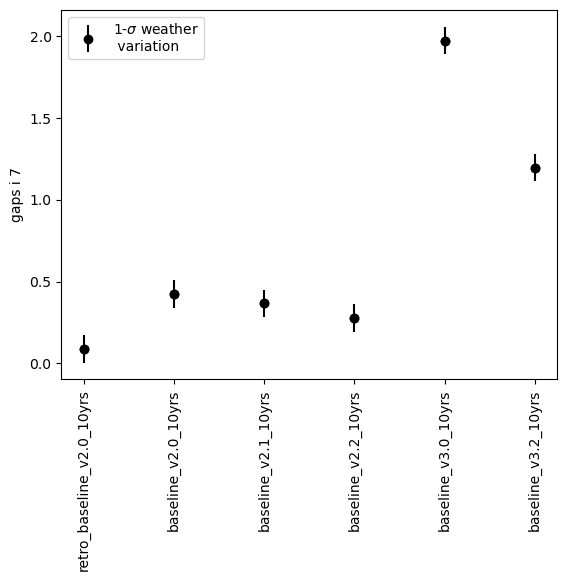

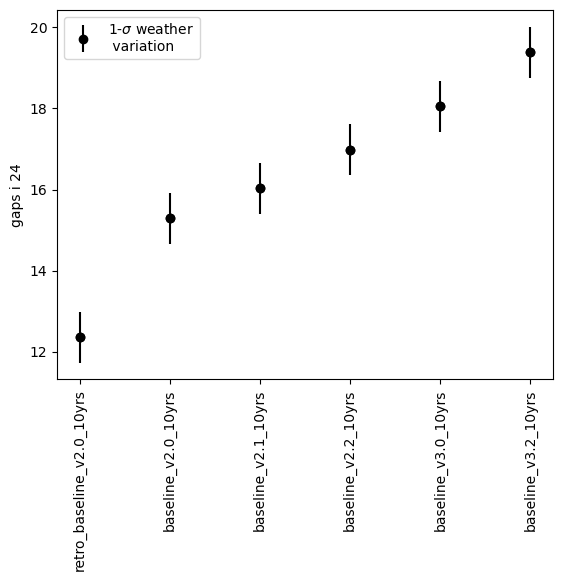

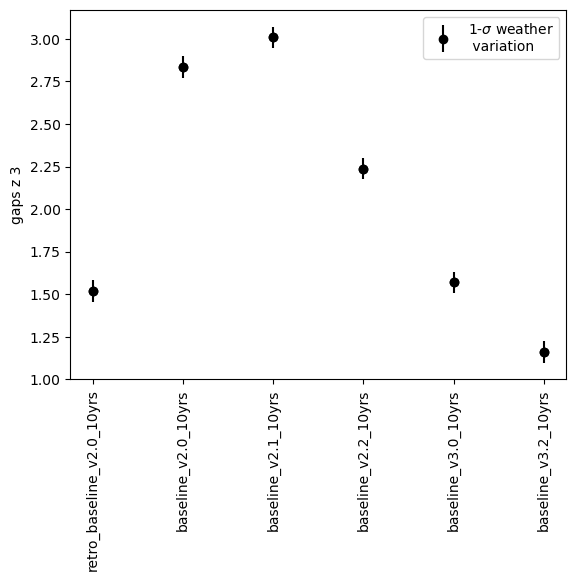

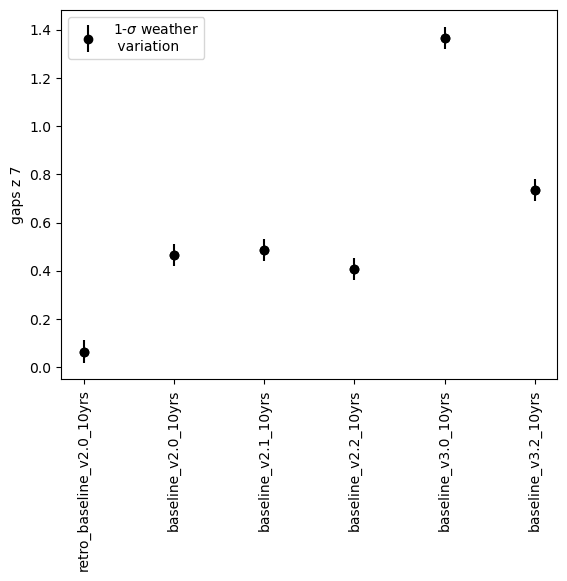

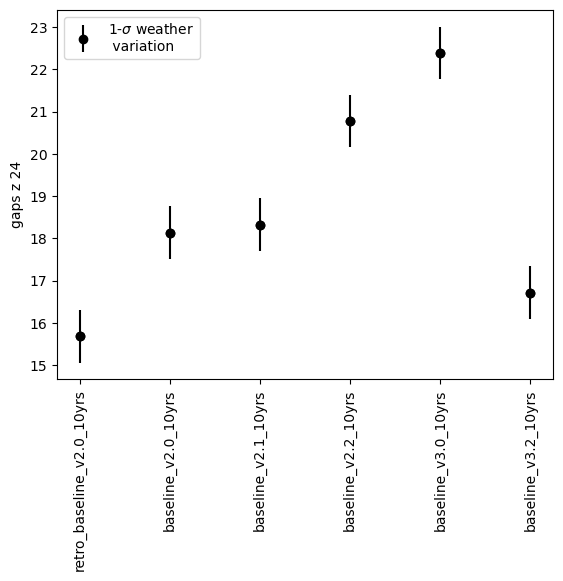

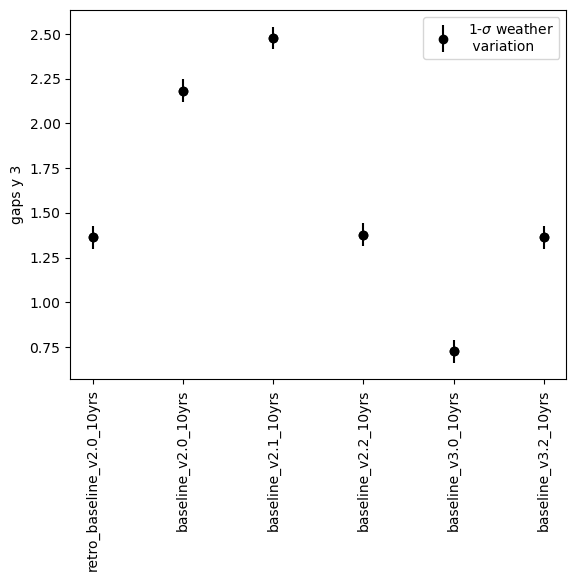

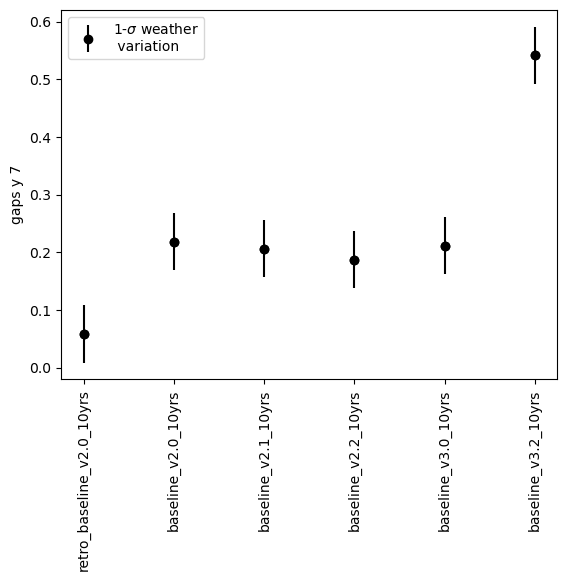

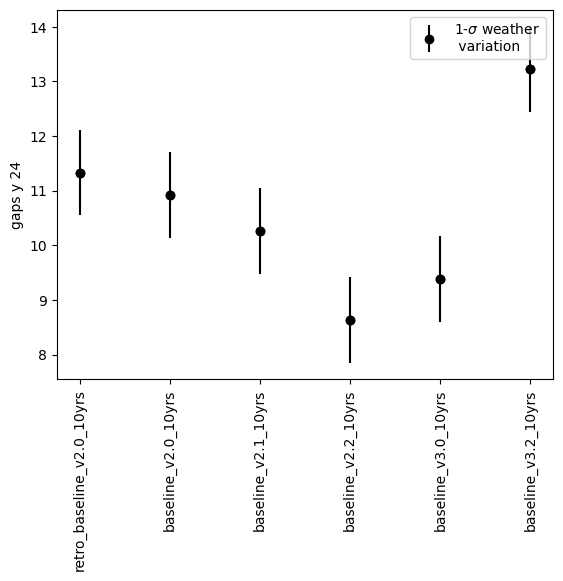

In [23]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


In [24]:
# so, we can think about what summary stats make the most sense for gaps. Might be top 18k sq degrees

In [25]:
times = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'filter' in run and 'short' not in run]
sub_gaps = gaps_data.reindex(labels=times)


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


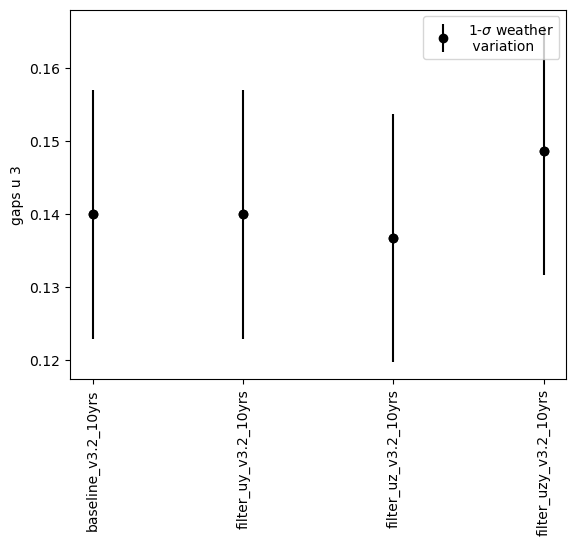

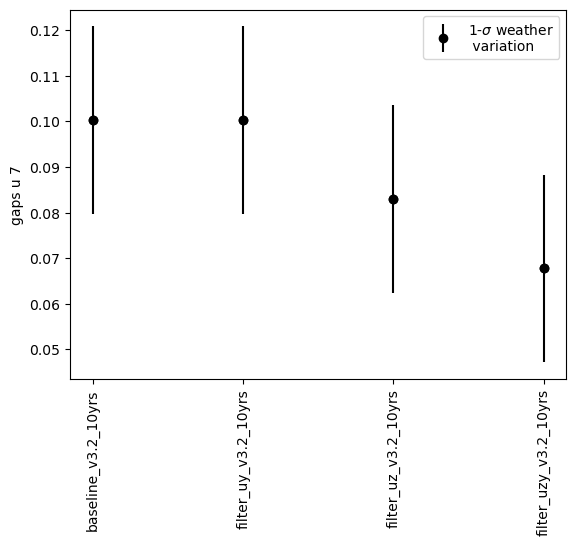

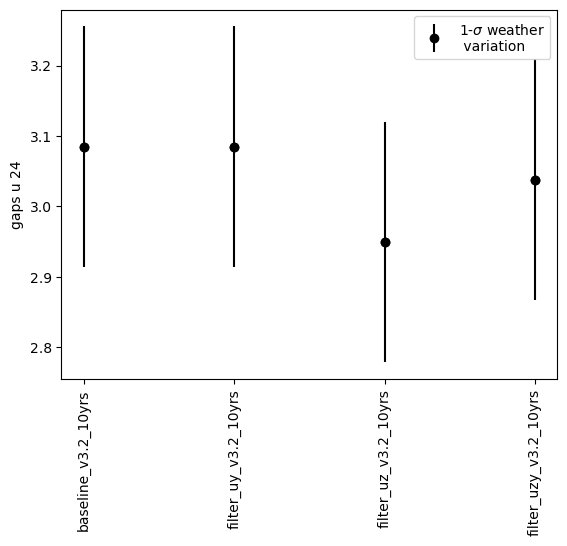

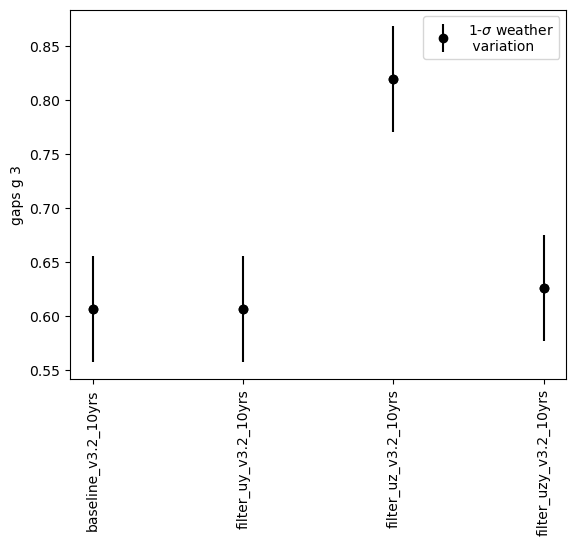

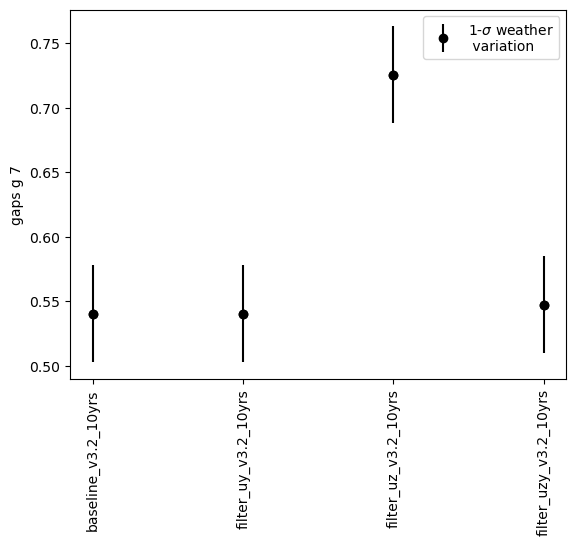

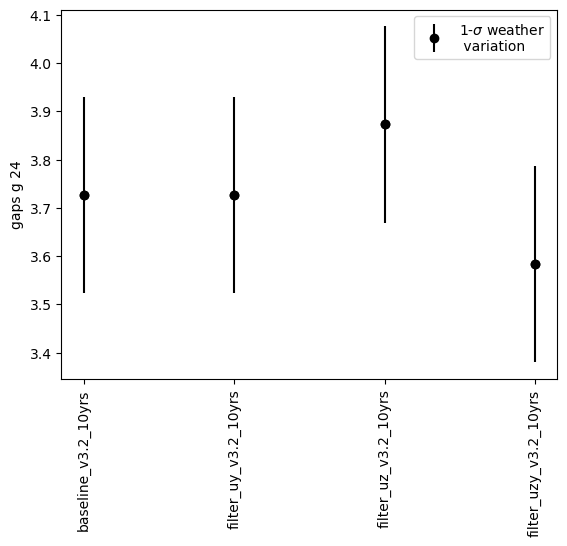

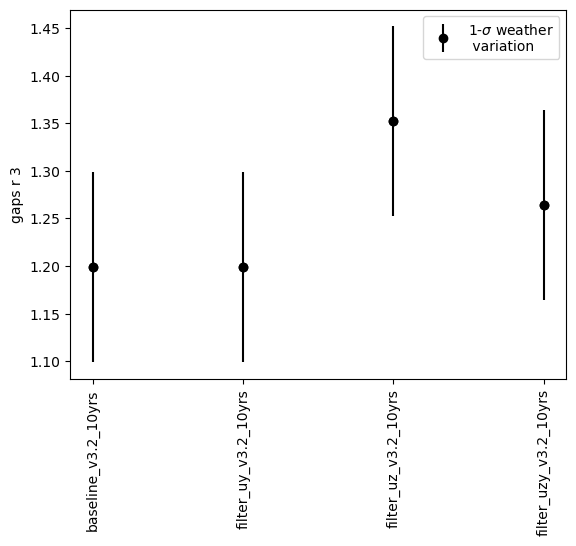

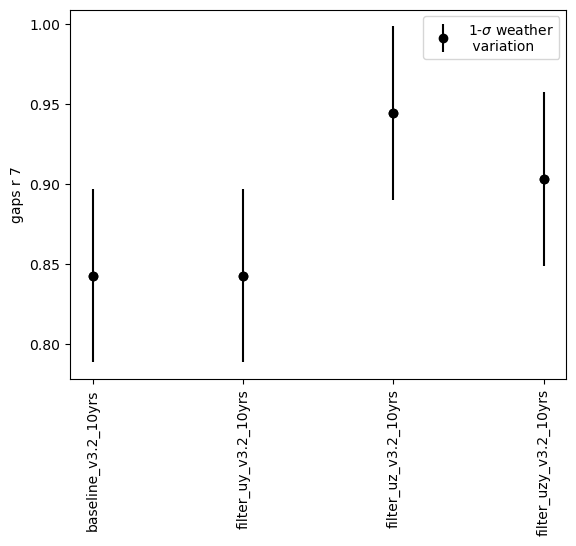

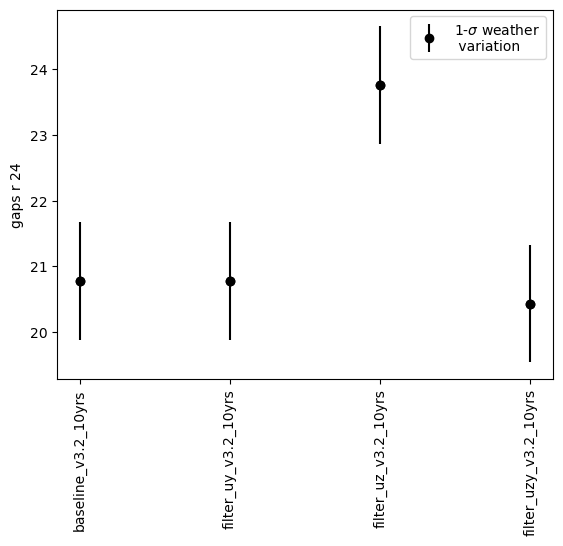

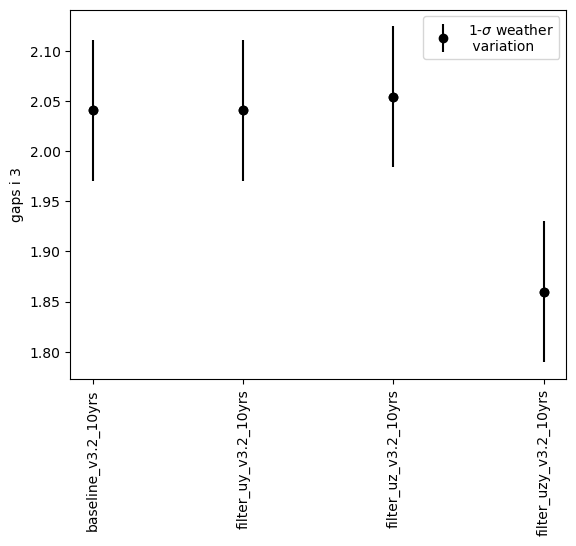

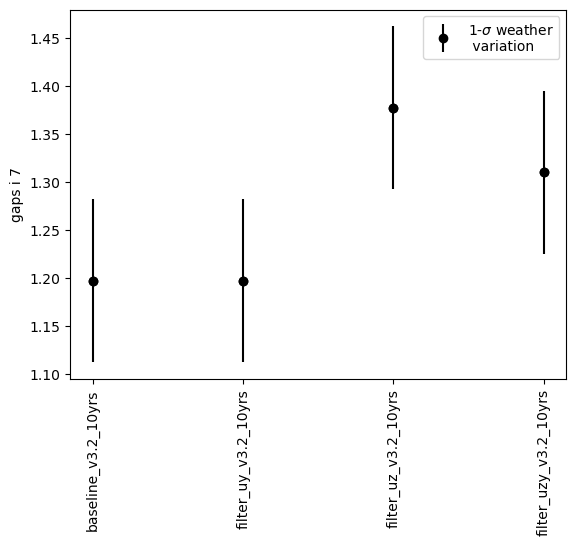

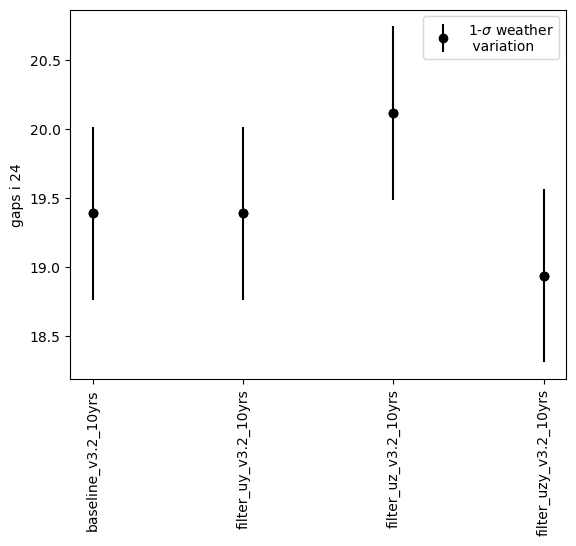

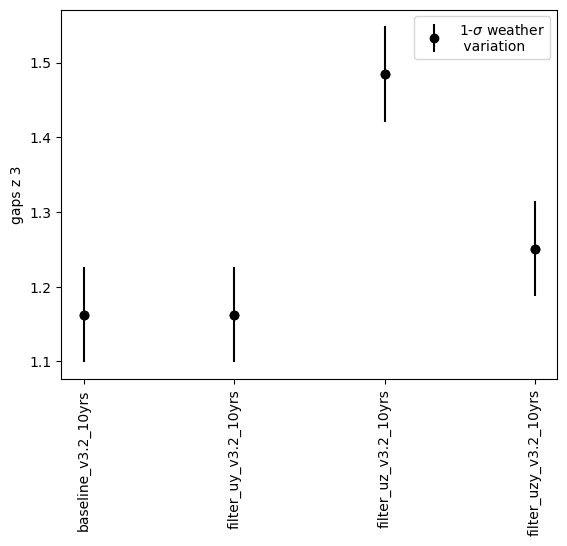

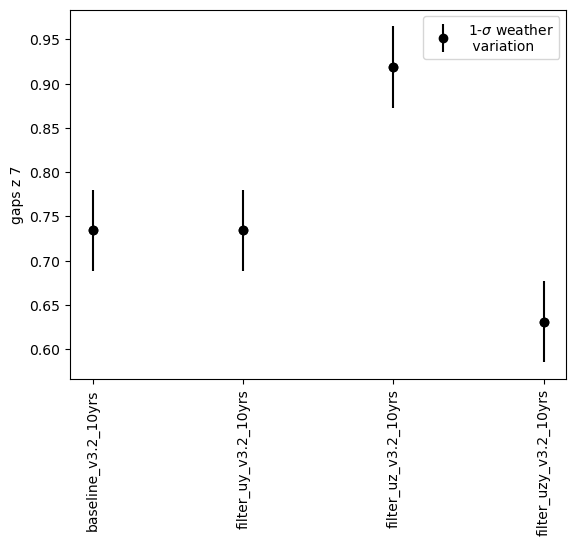

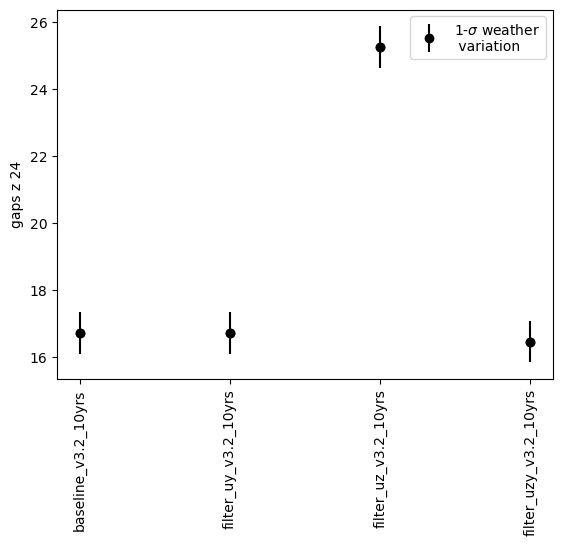

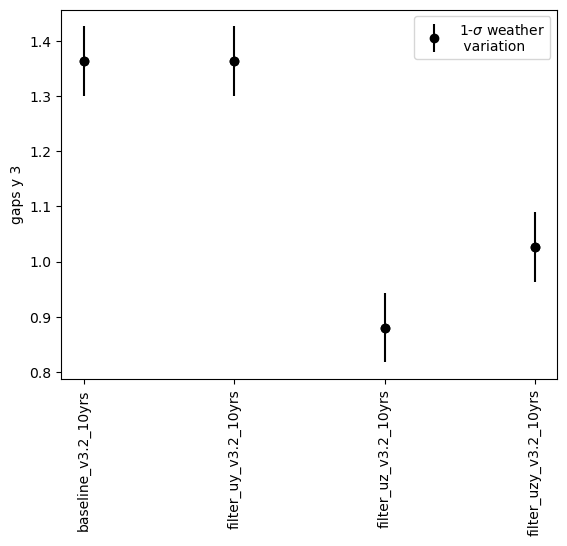

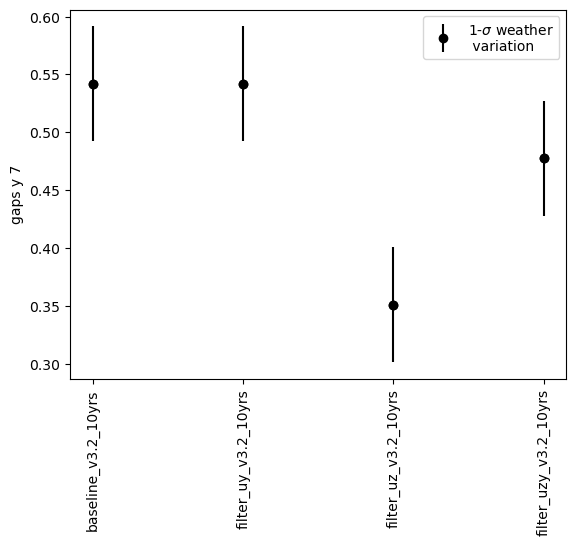

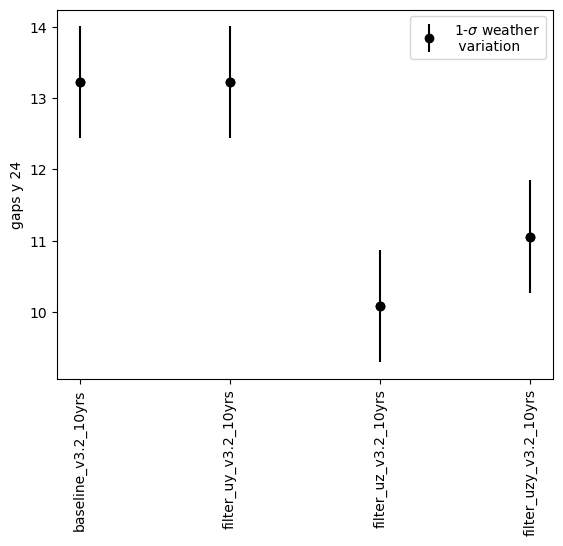

In [26]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/526031158.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


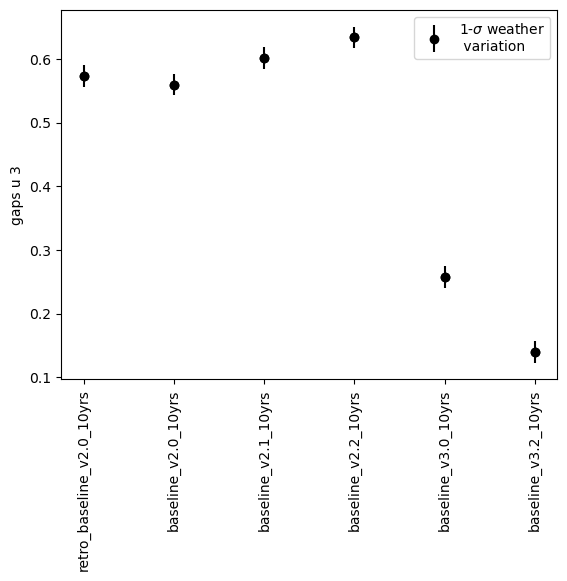

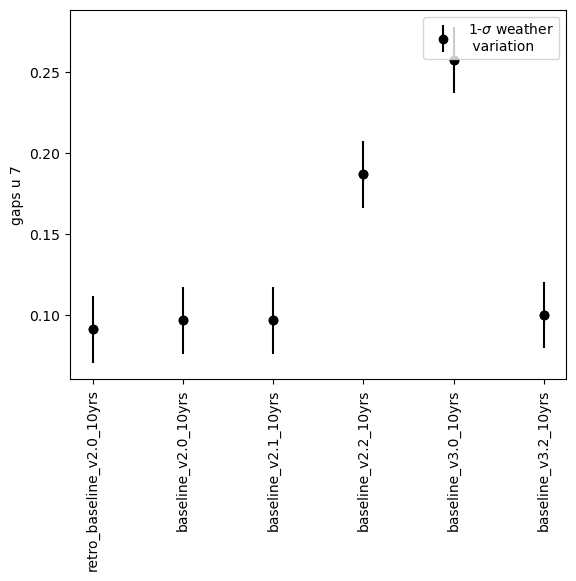

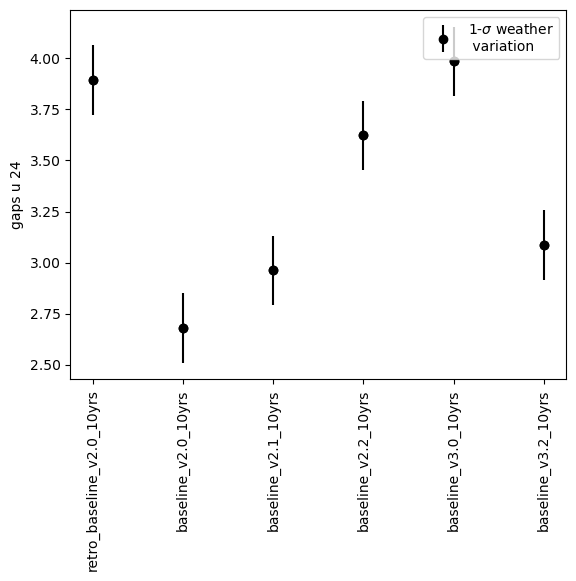

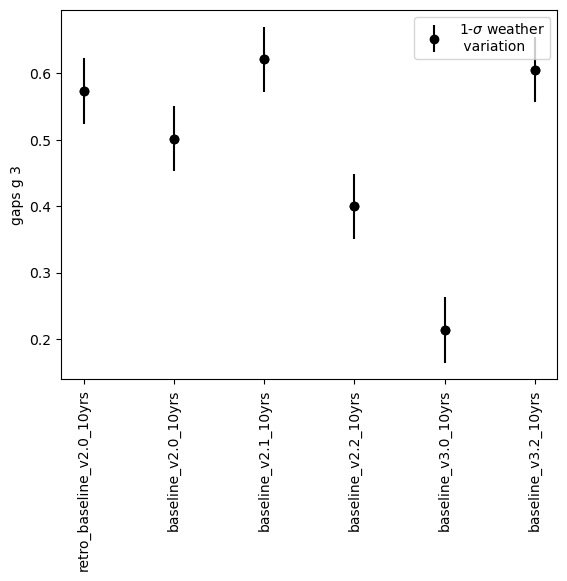

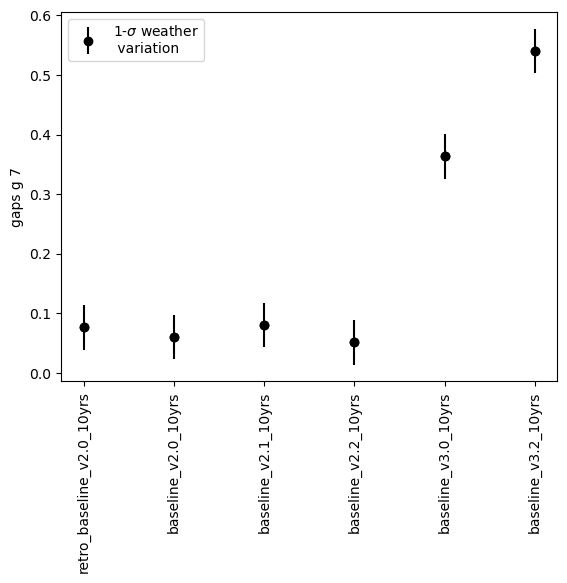

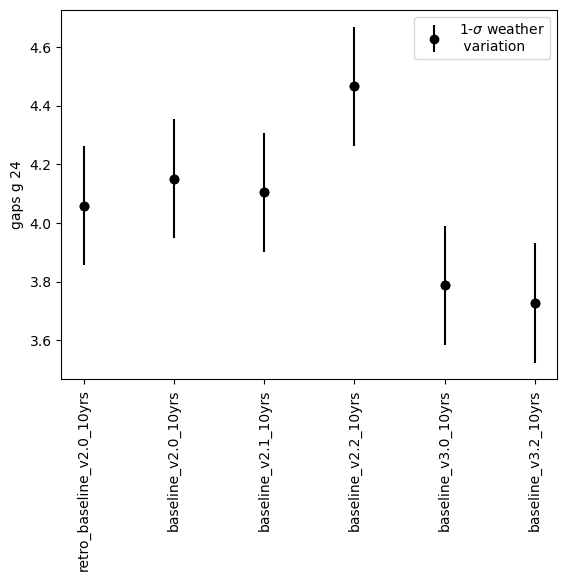

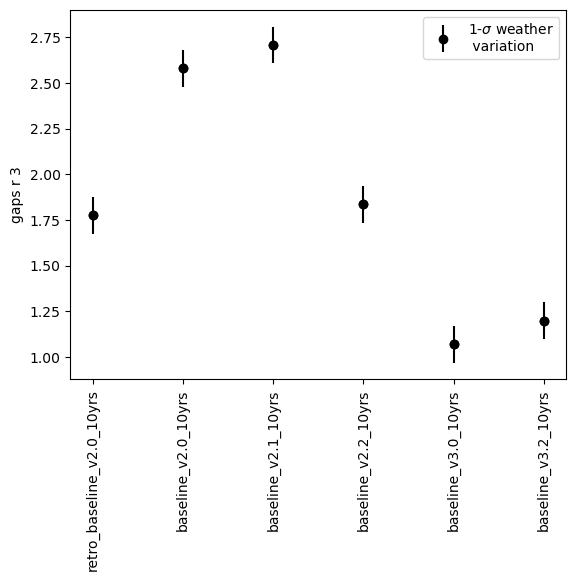

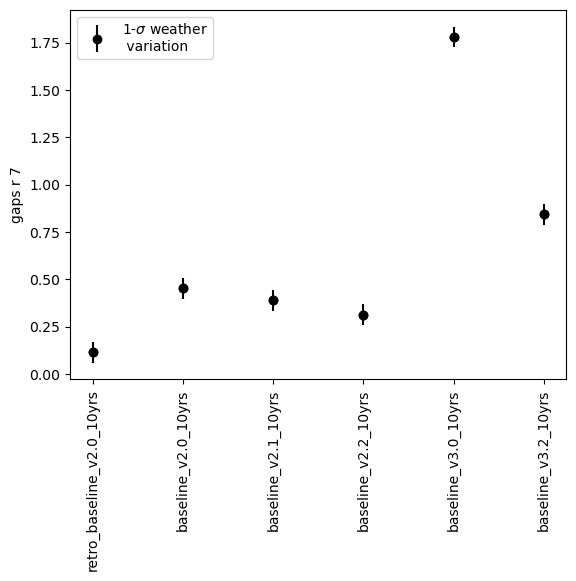

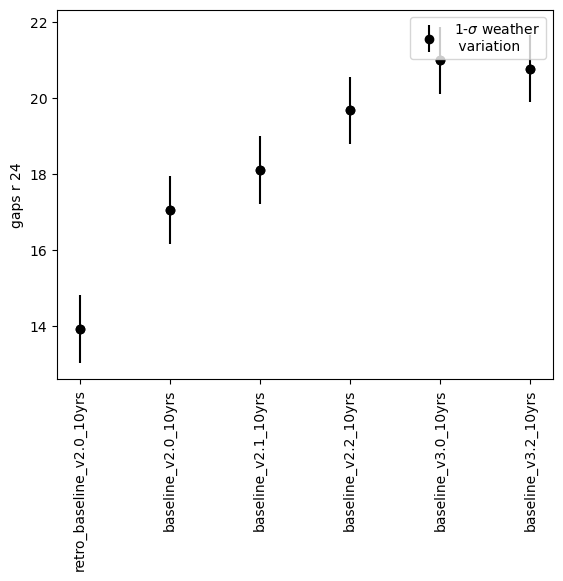

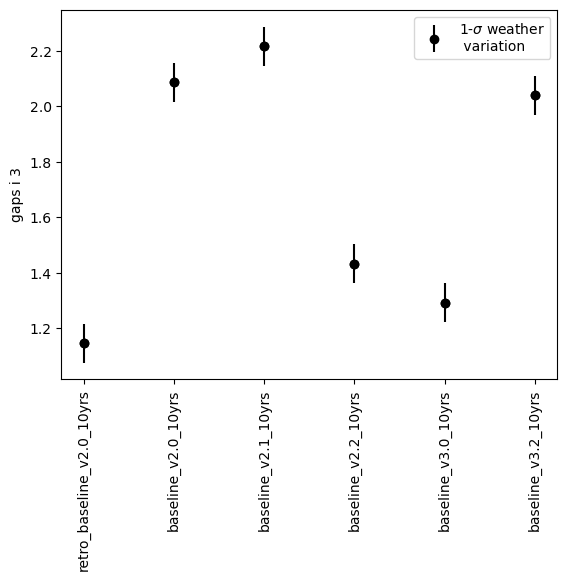

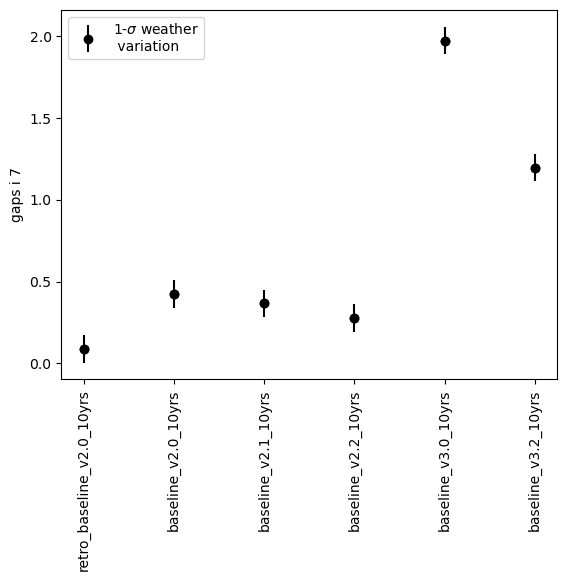

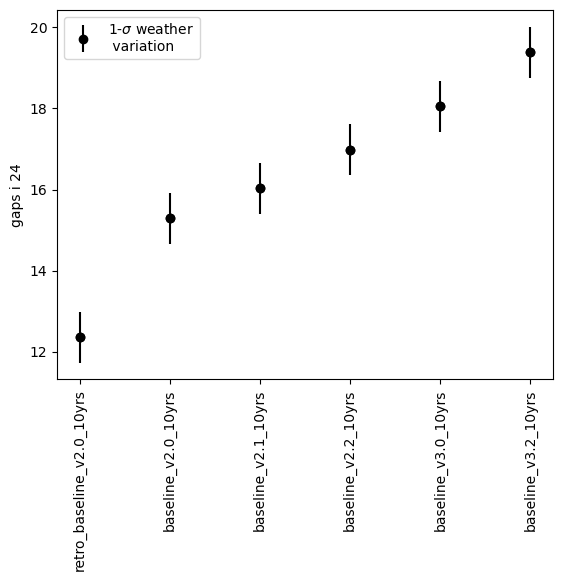

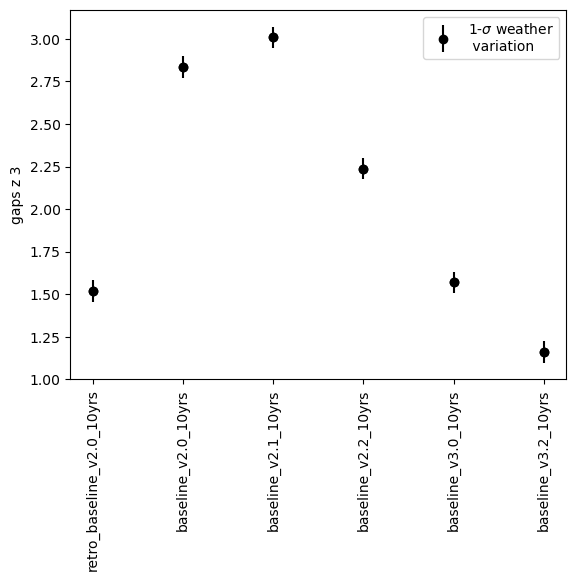

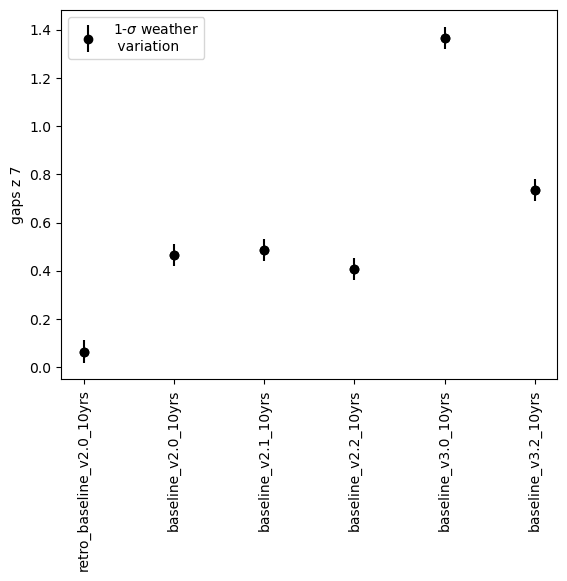

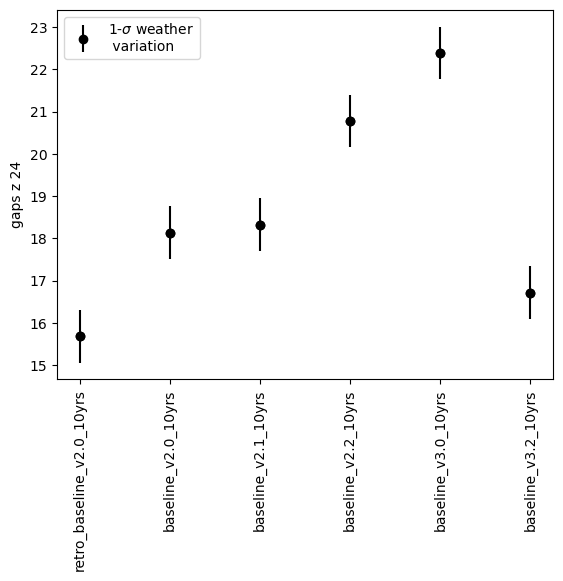

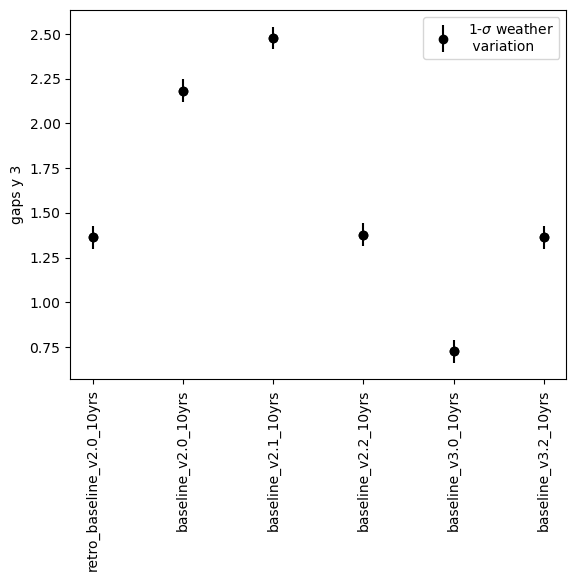

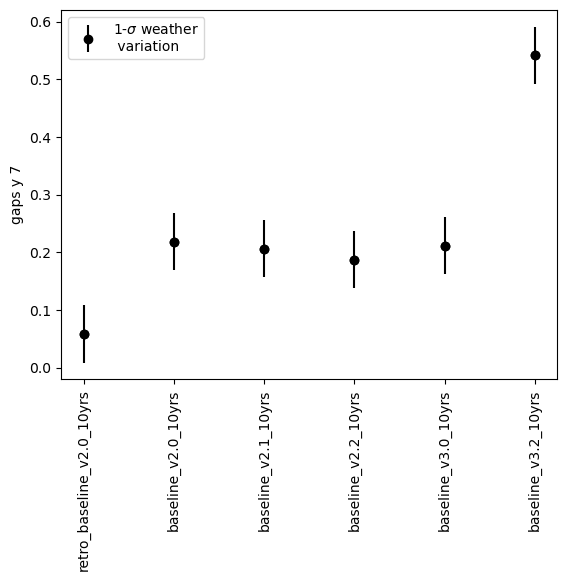

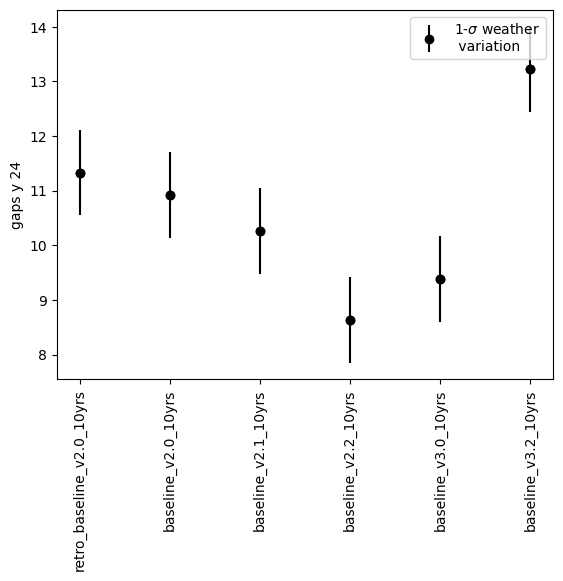

In [27]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs']

sub_gaps = gaps_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/3623228712.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


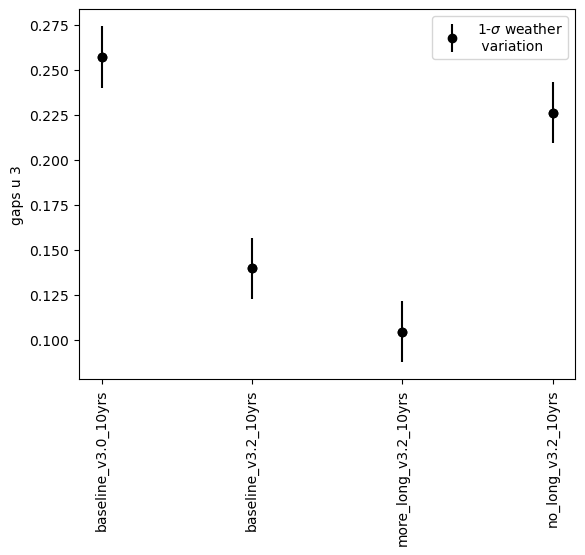

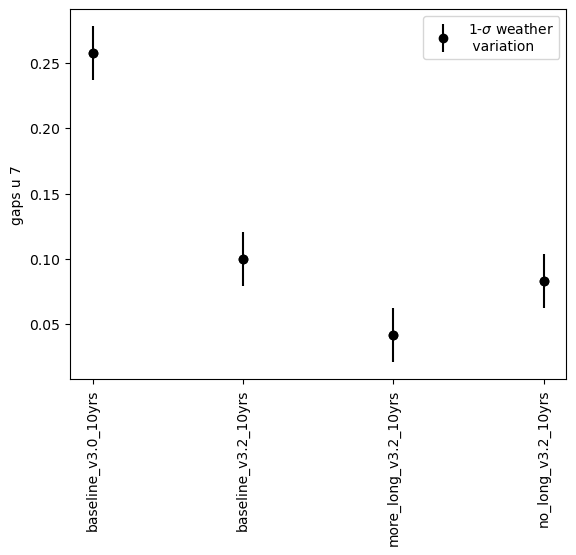

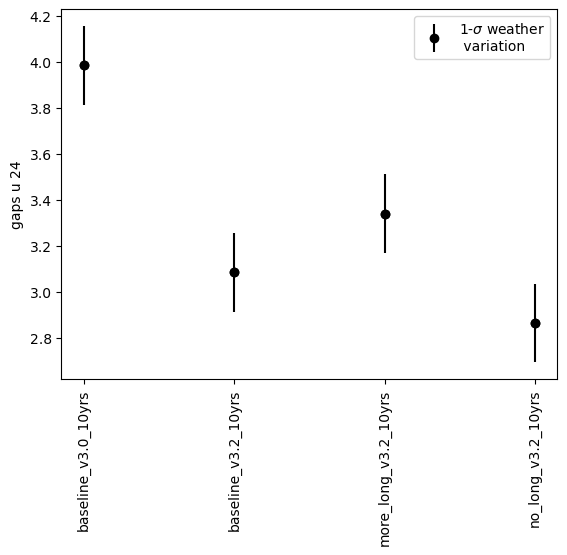

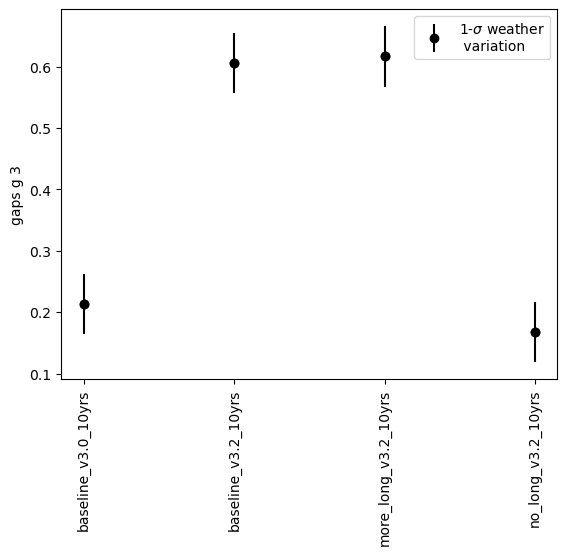

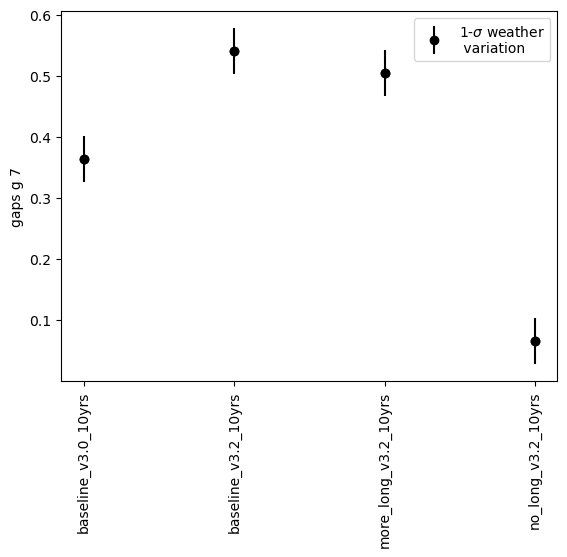

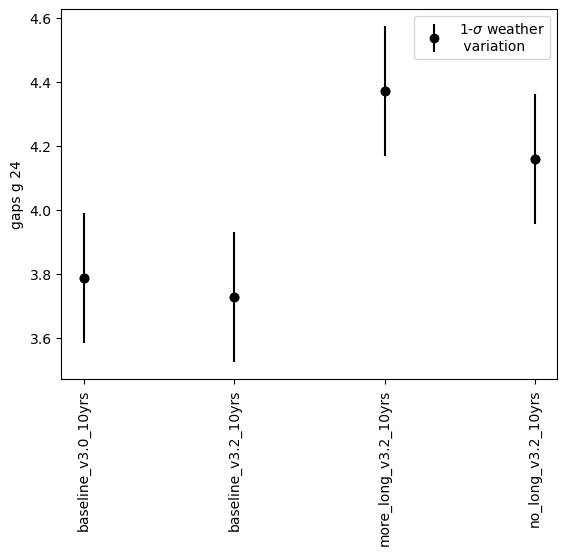

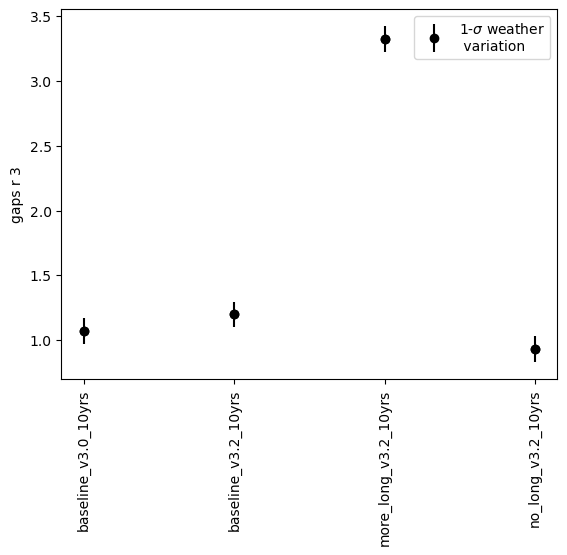

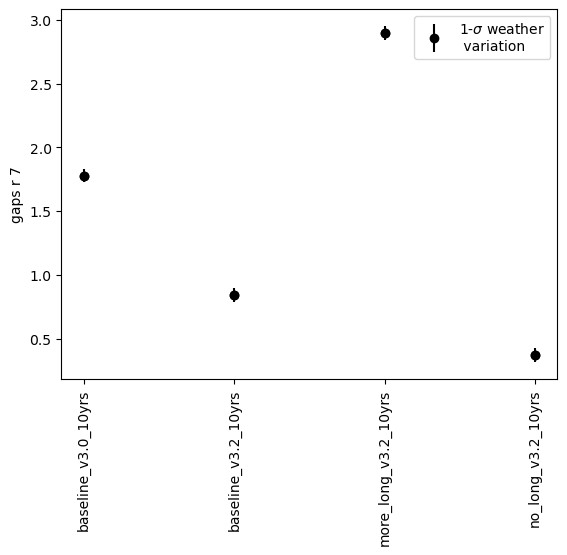

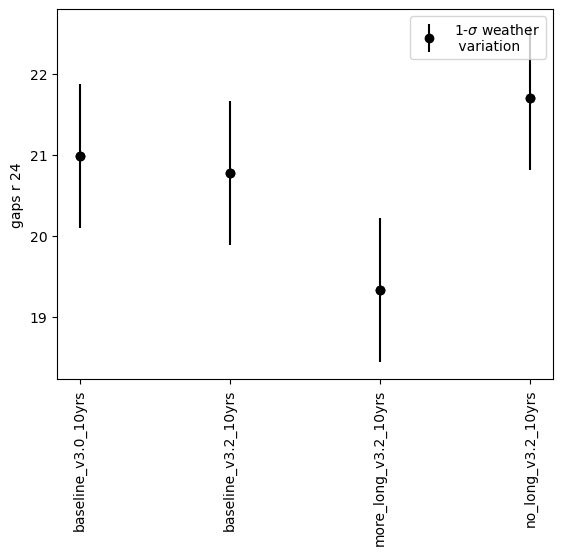

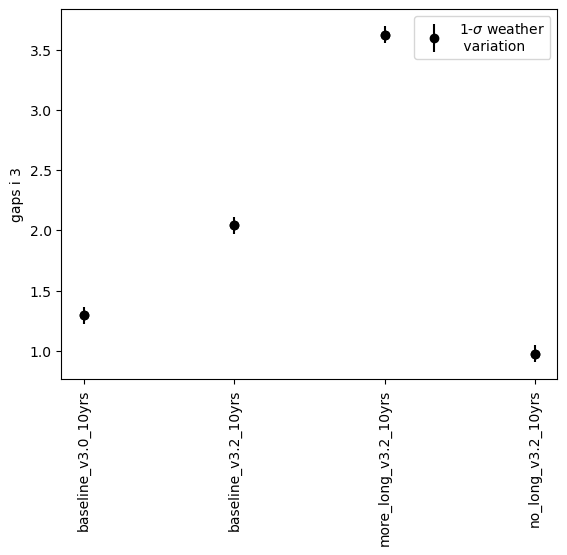

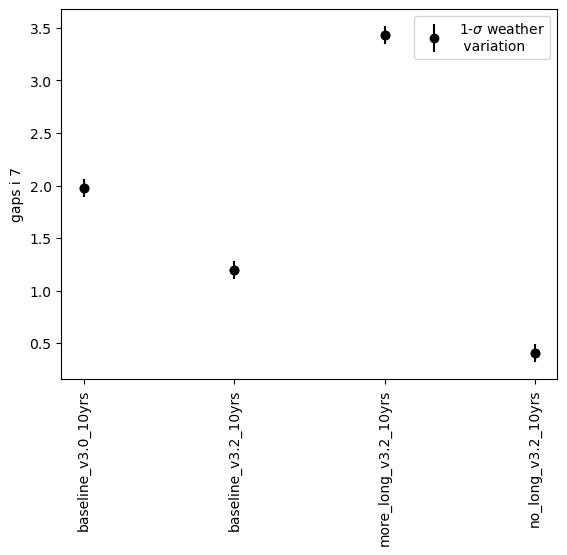

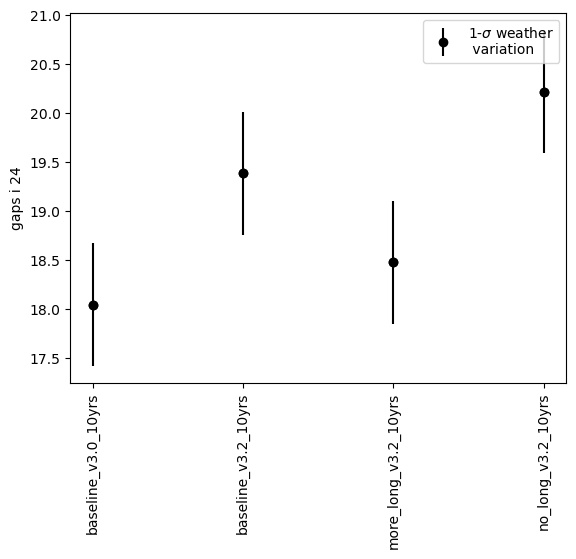

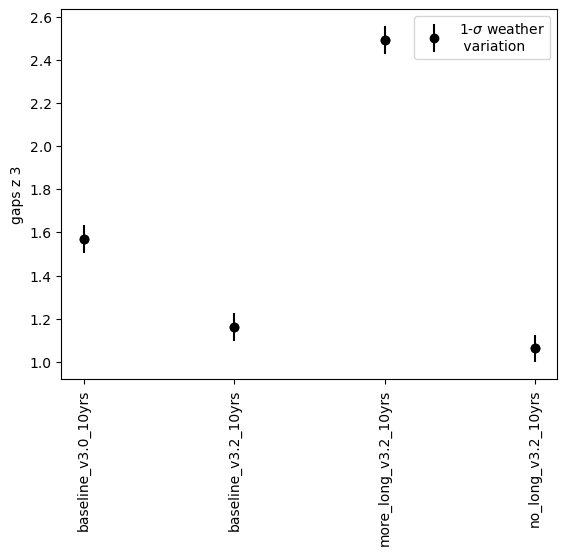

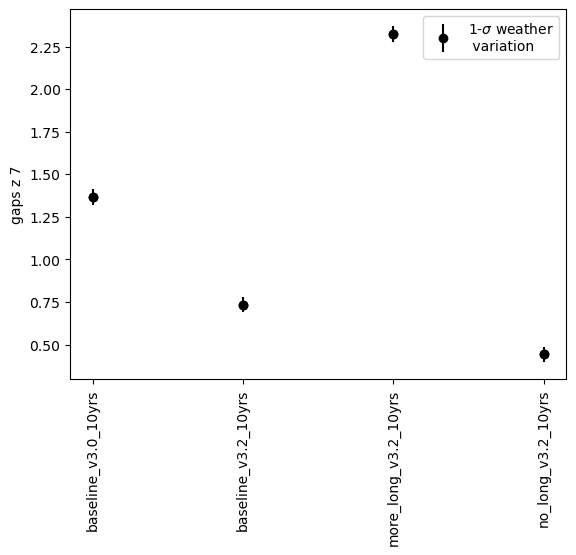

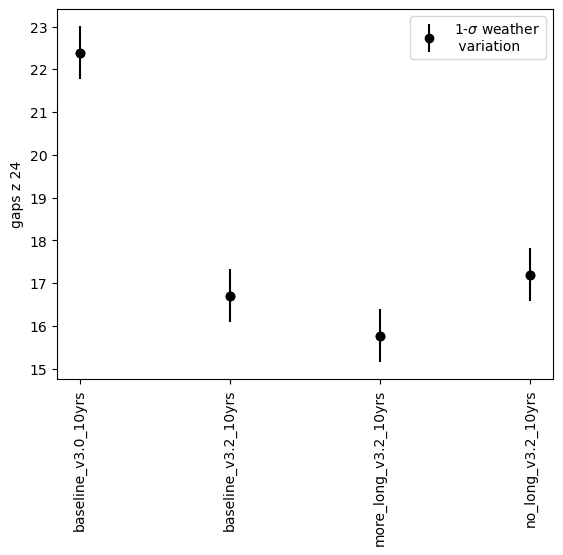

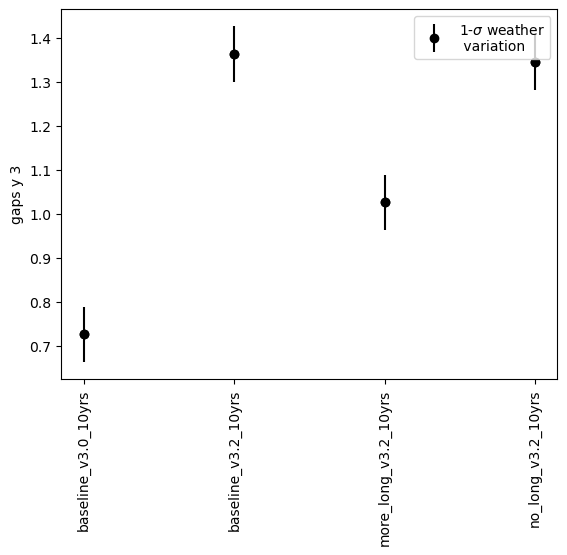

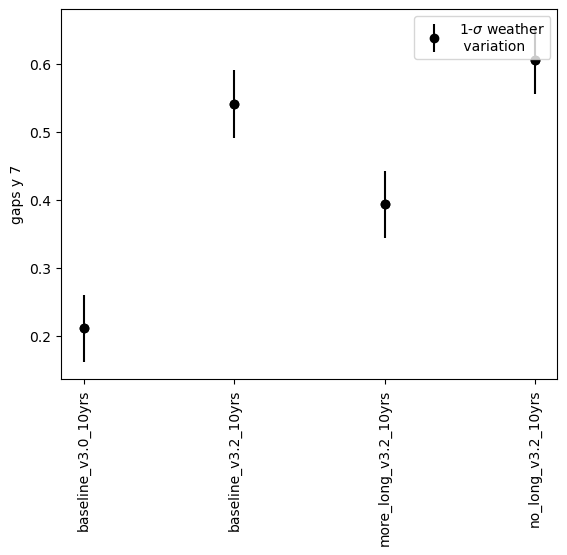

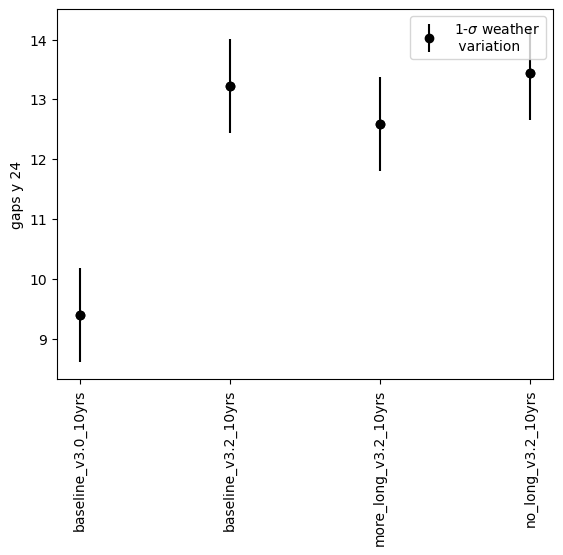

In [28]:
times = ['baseline_v3.0_10yrs',  'baseline_v3.2_10yrs'] + [run for run in data.index if '_long' in run]

sub_gaps = gaps_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/2400977859.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


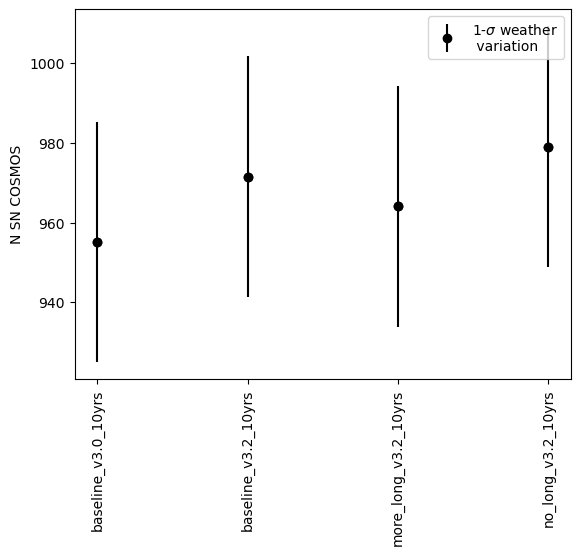

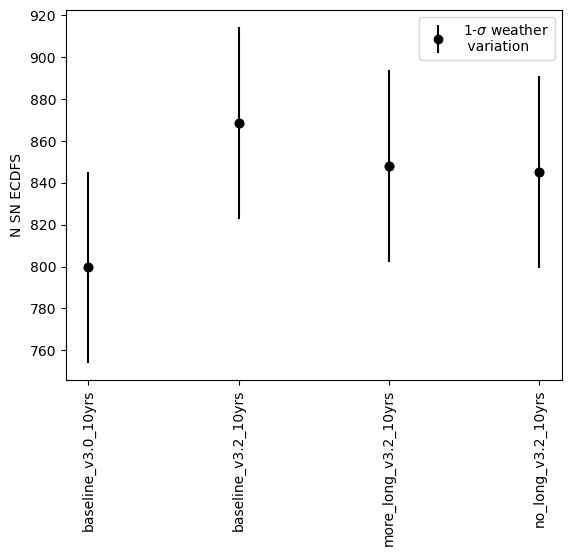

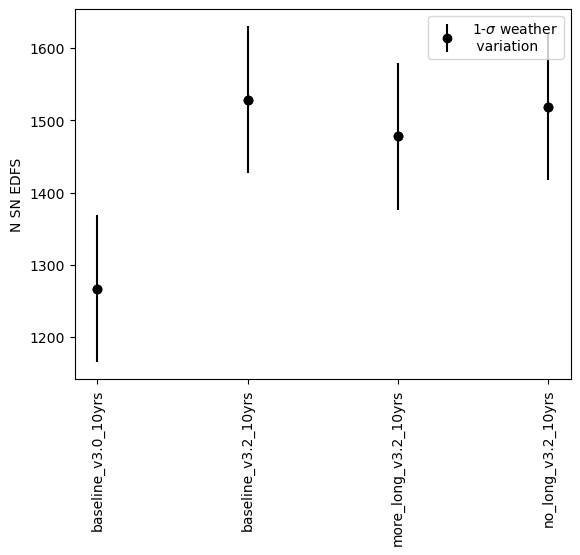

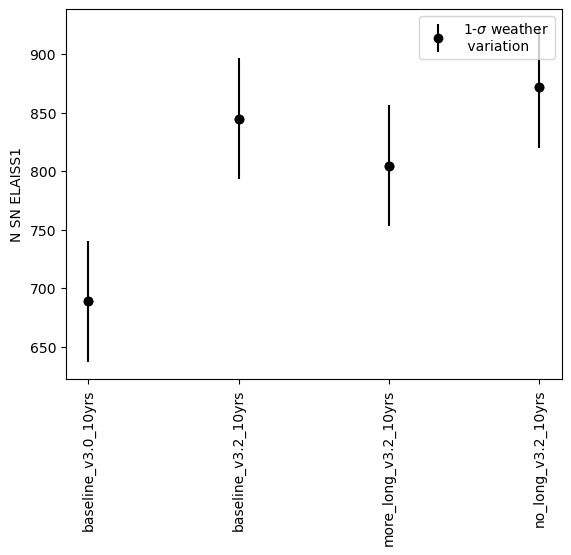

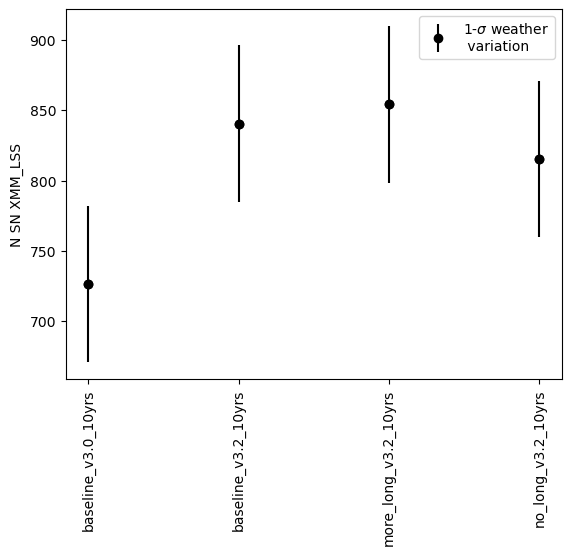

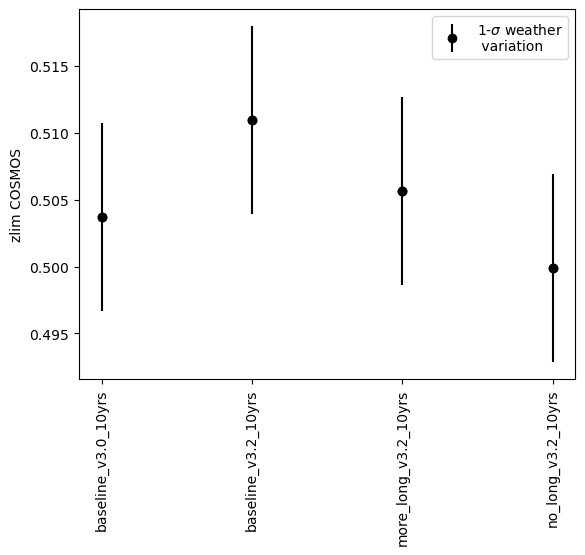

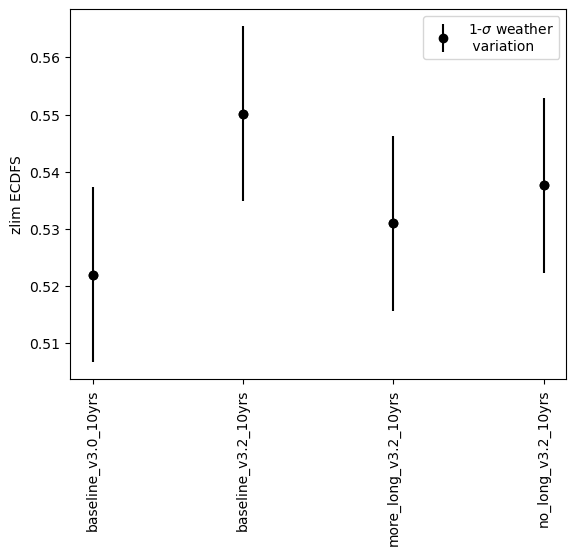

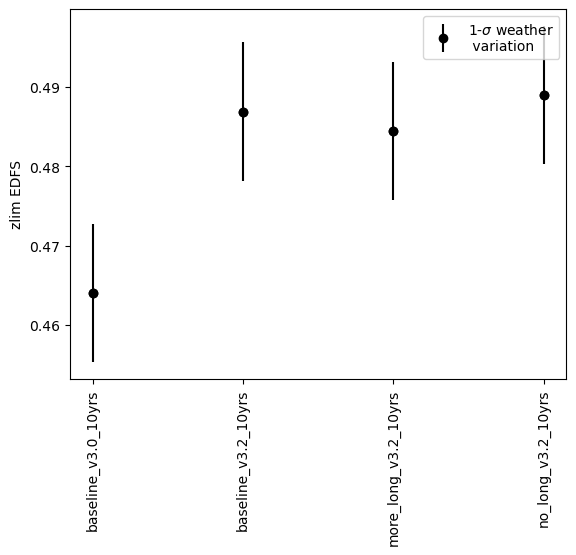

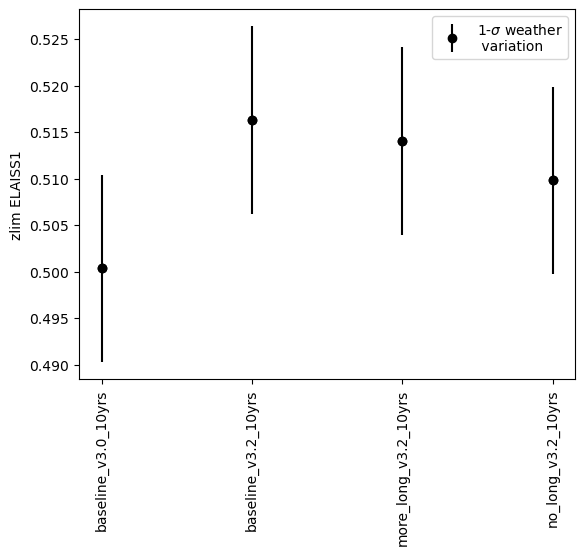

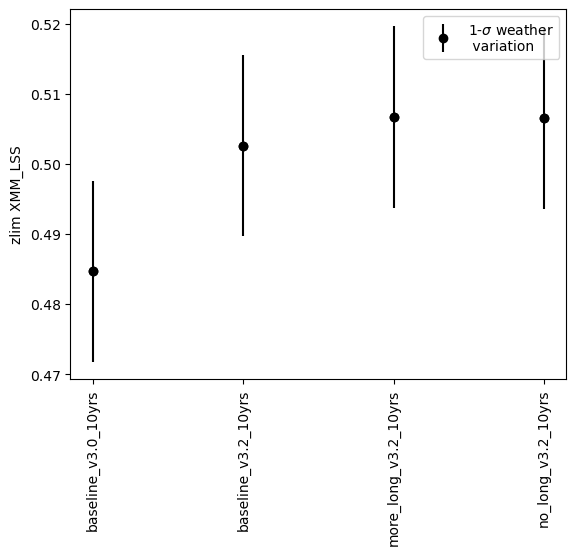

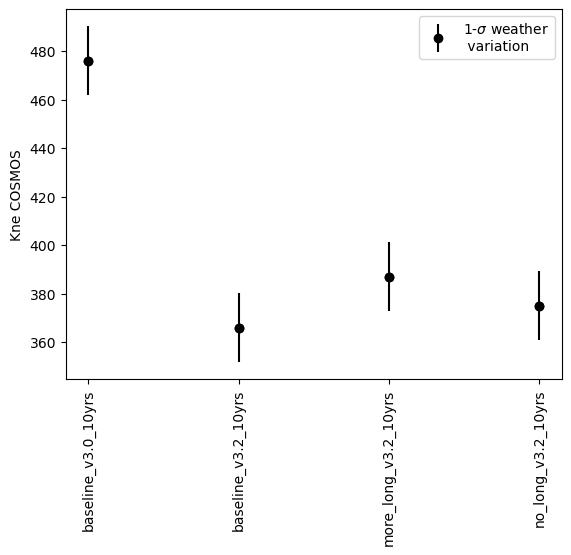

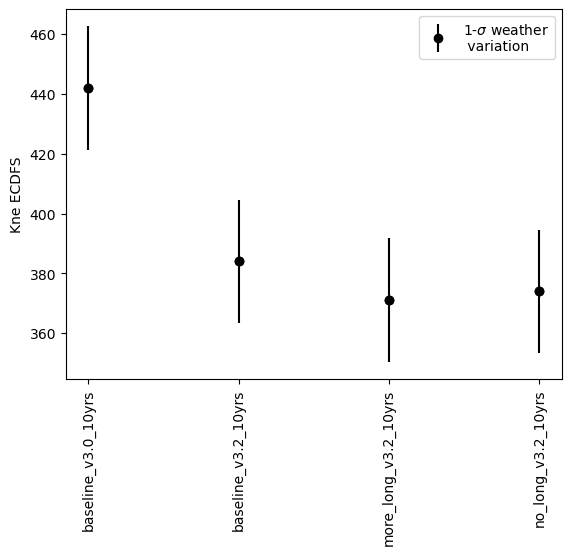

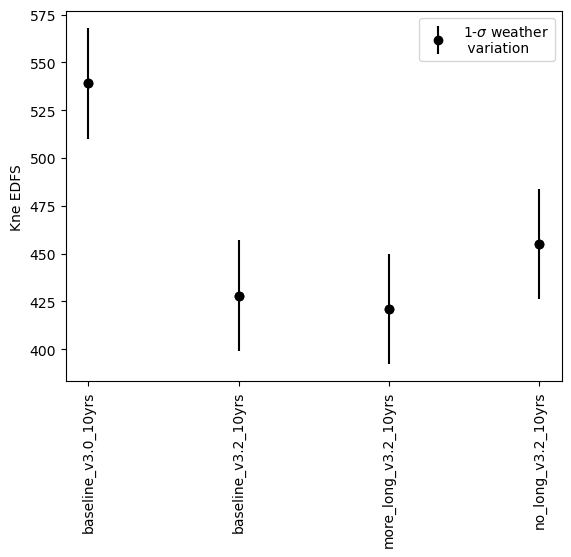

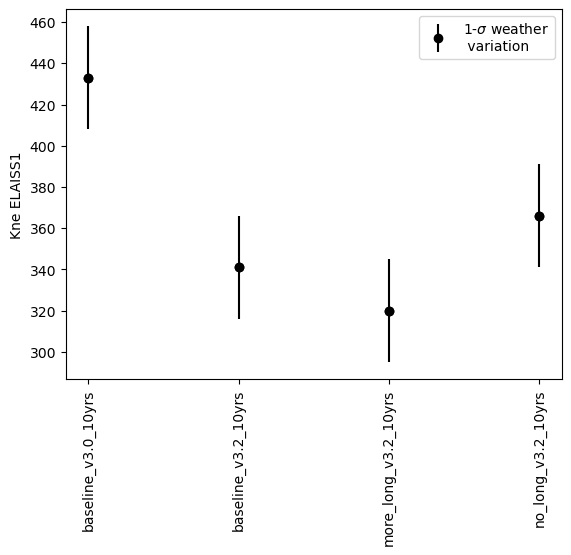

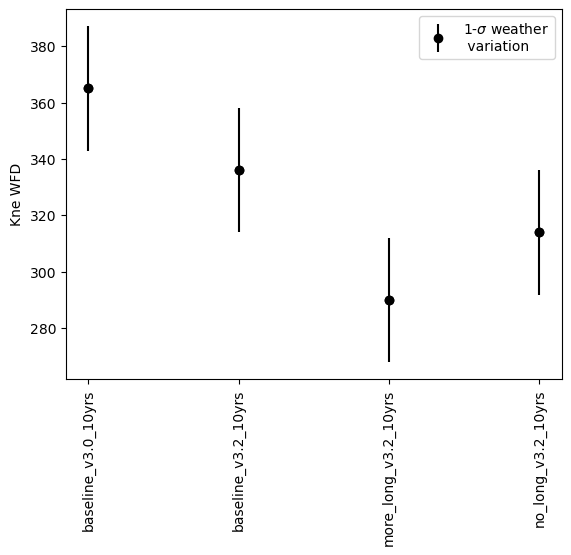

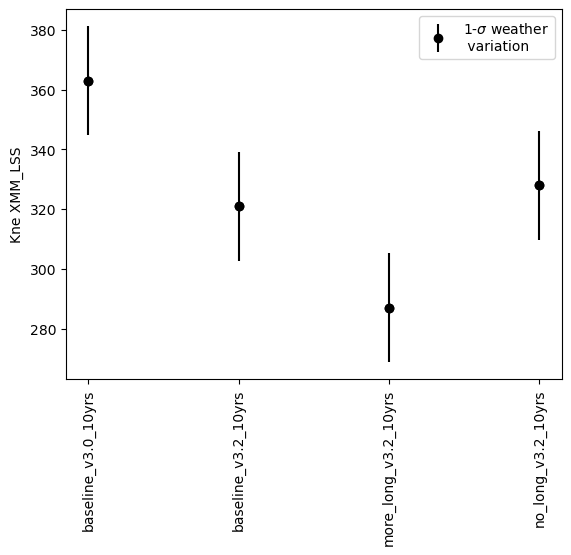

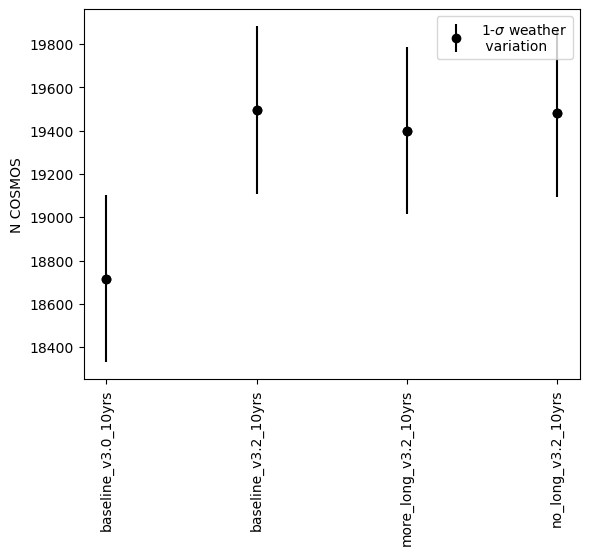

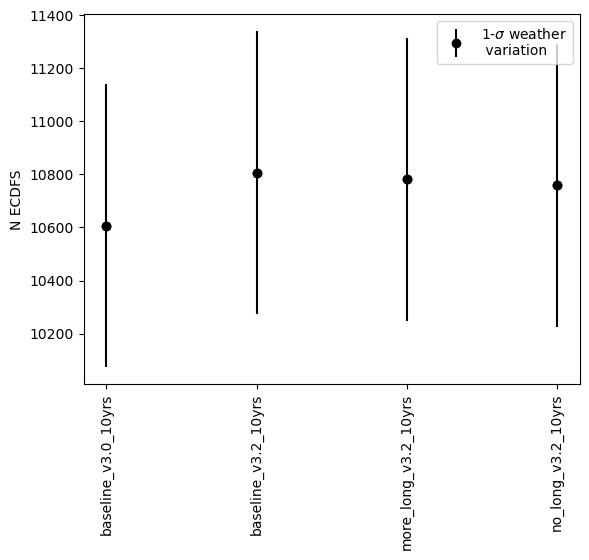

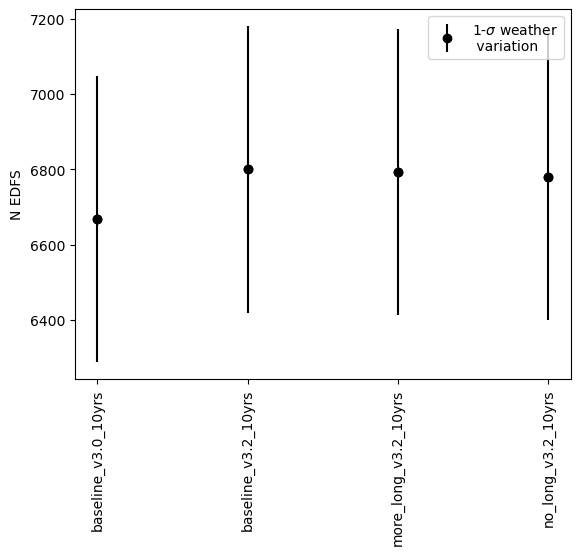

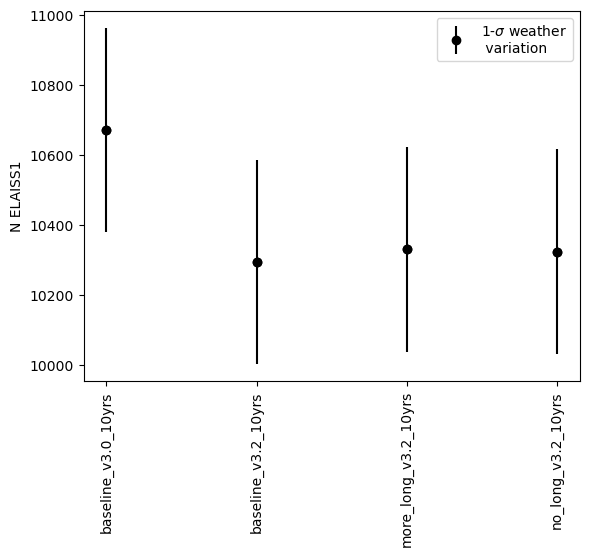

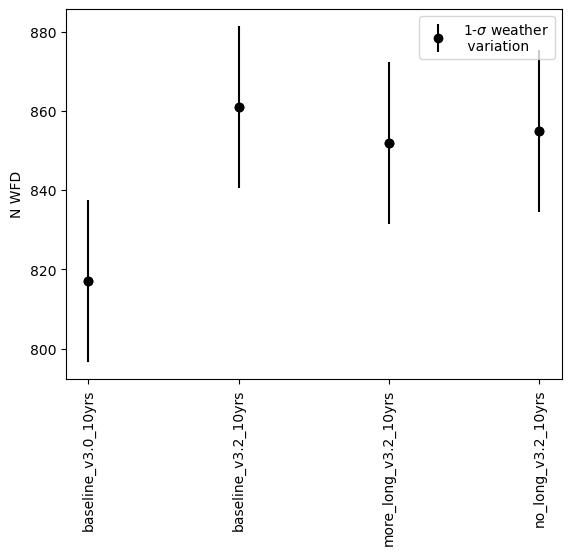

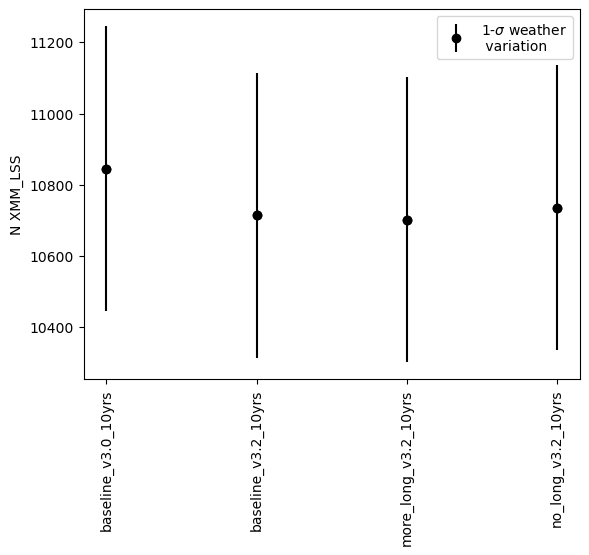

In [29]:
sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/1088104815.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


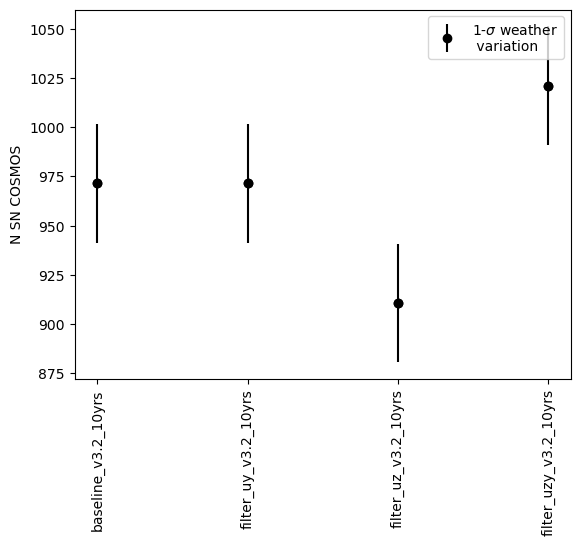

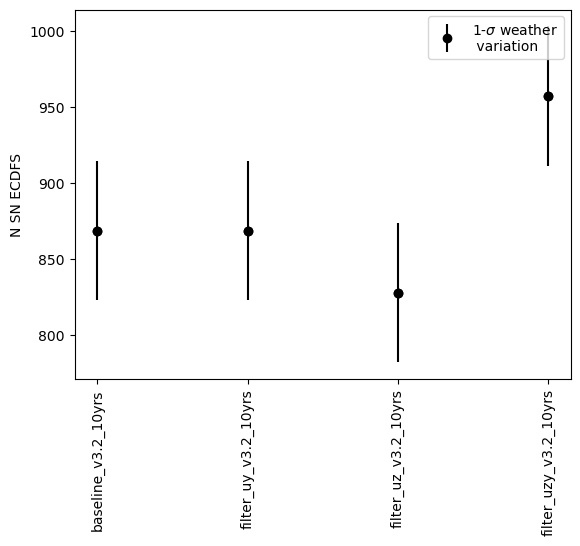

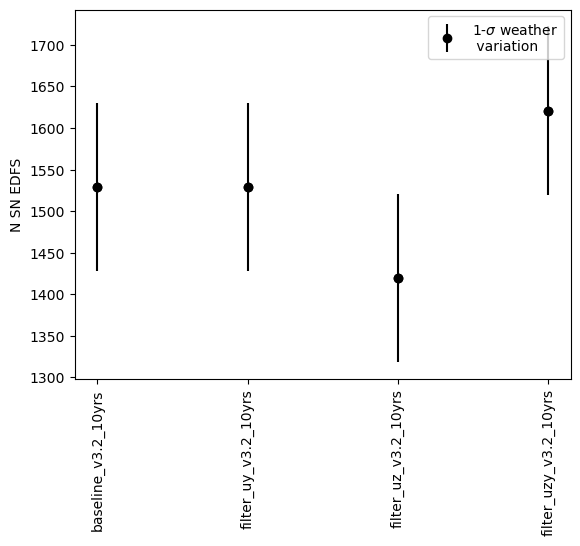

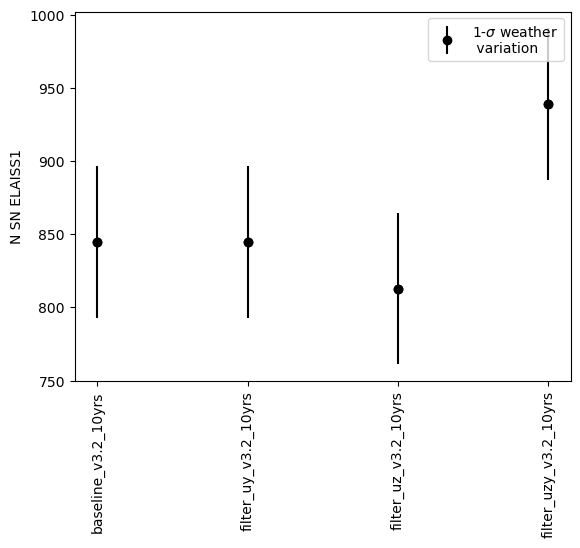

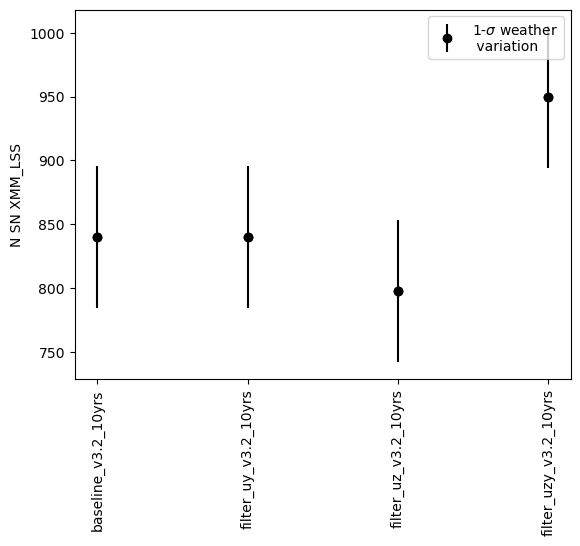

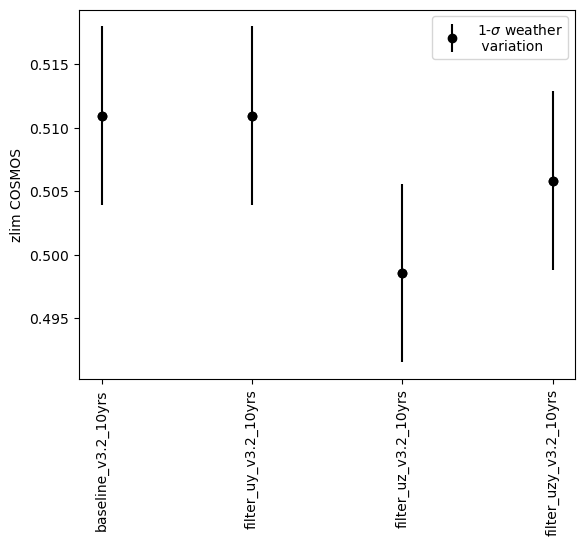

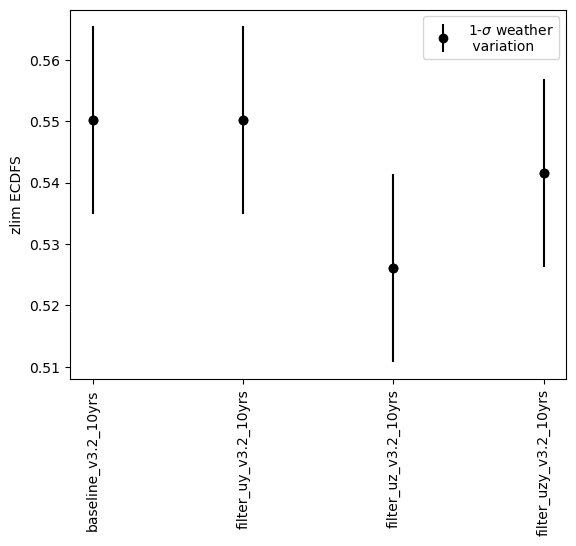

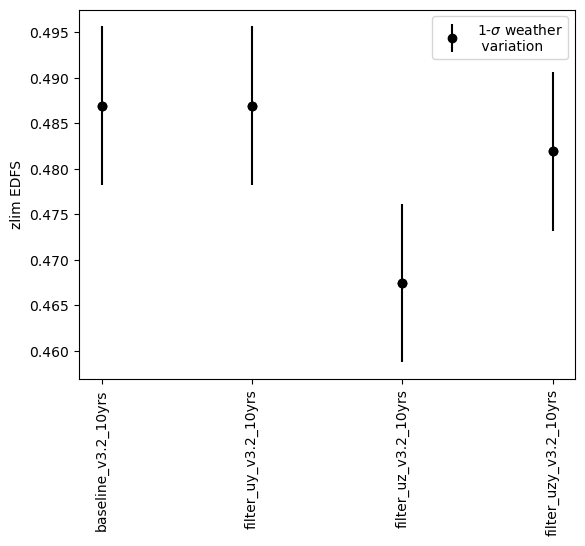

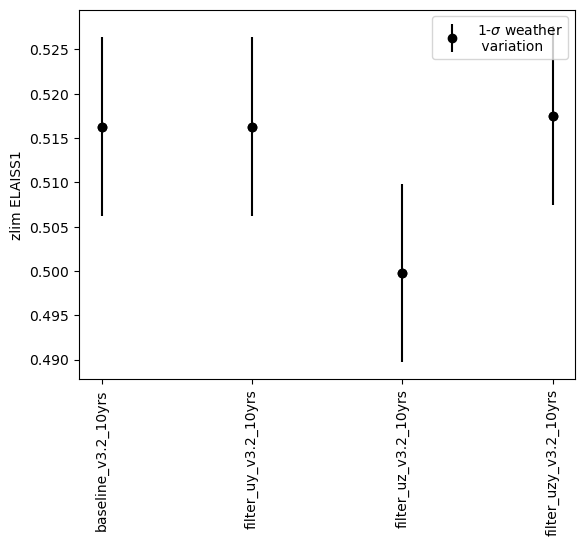

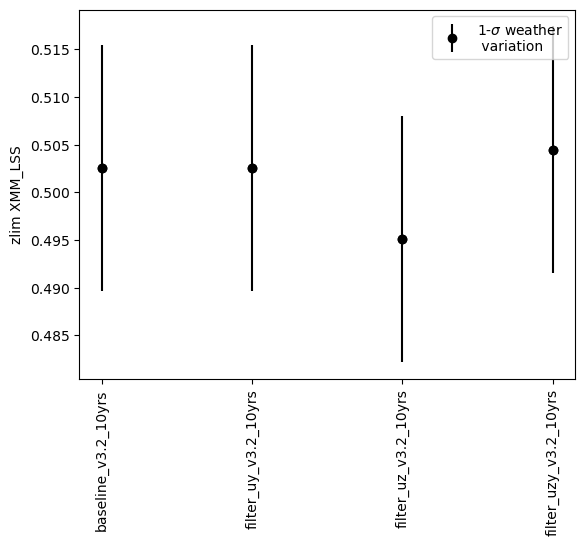

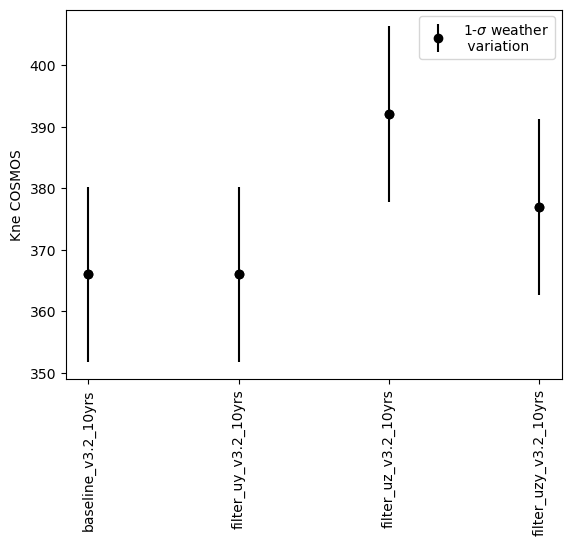

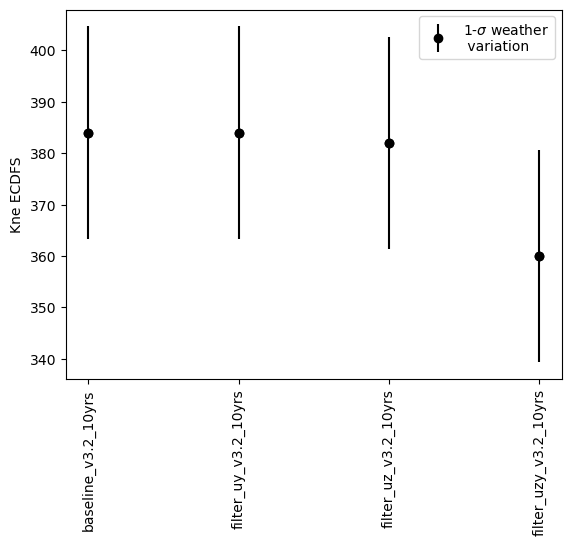

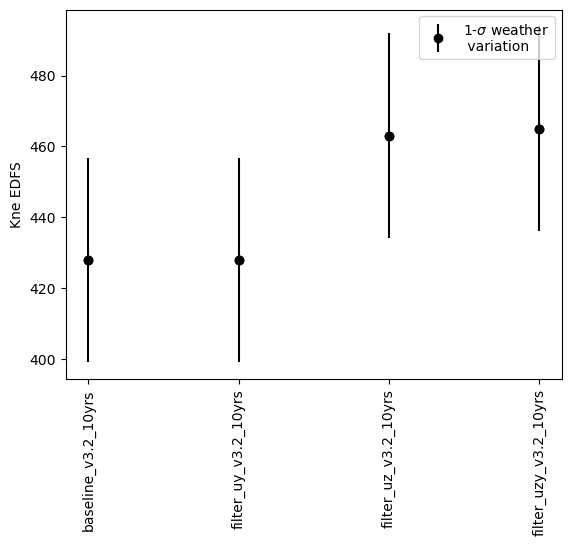

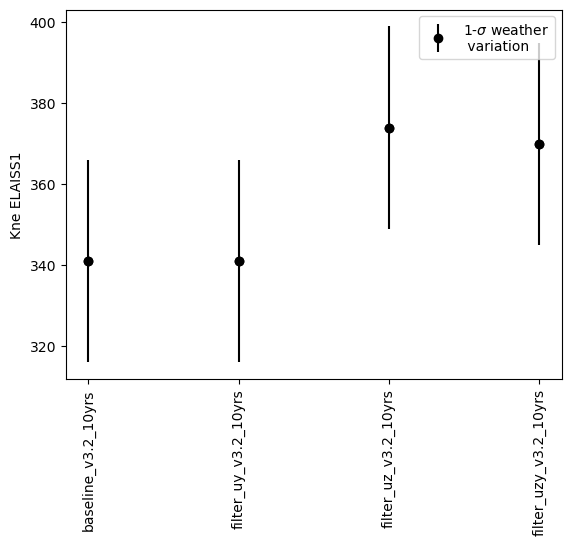

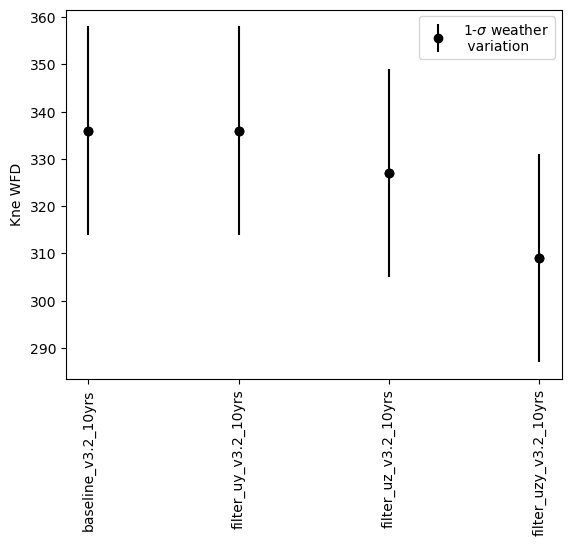

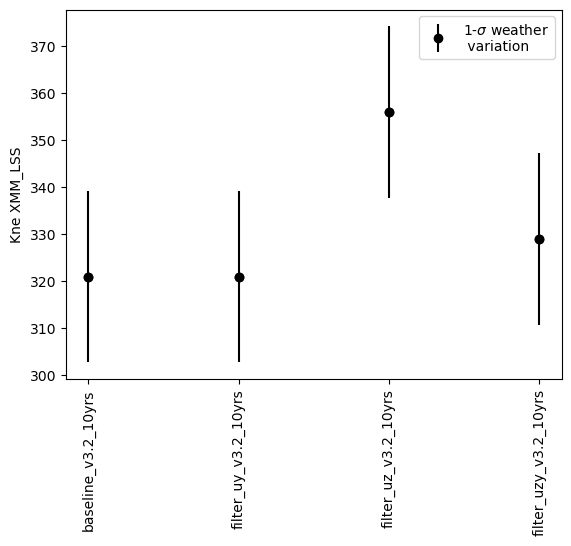

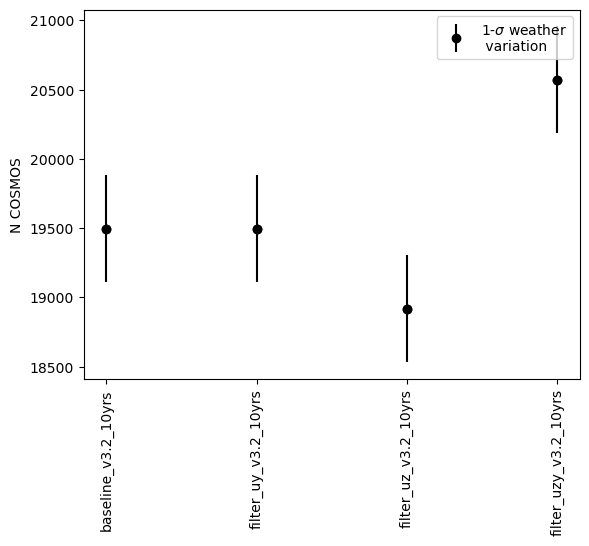

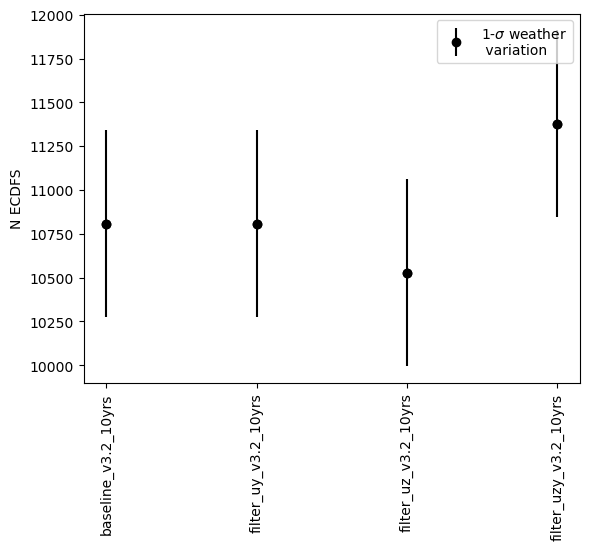

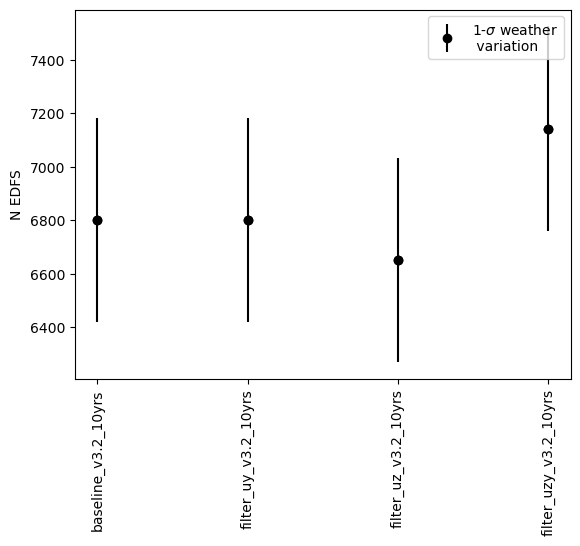

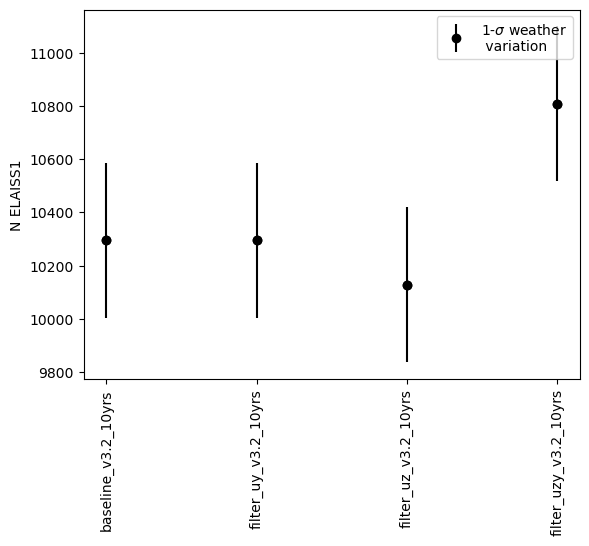

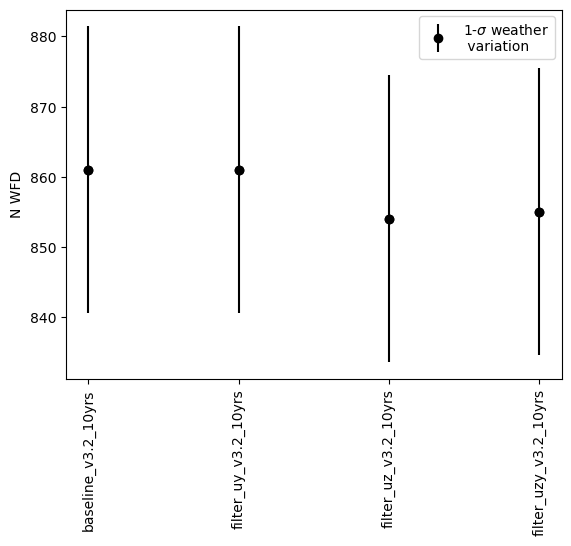

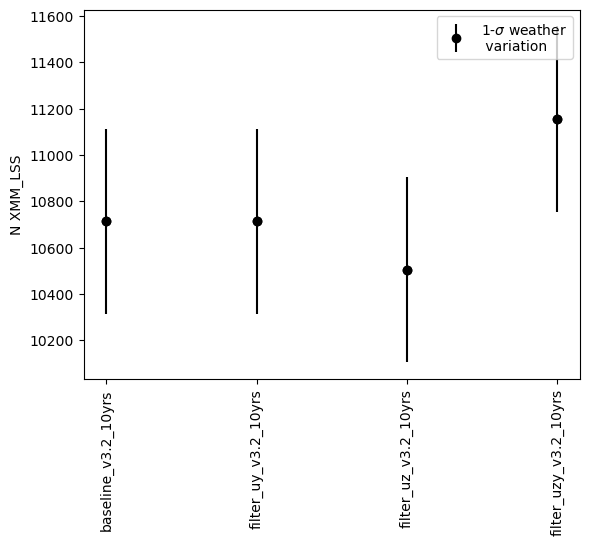

In [30]:

times = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'filter' in run]

sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_36485/2878332686.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


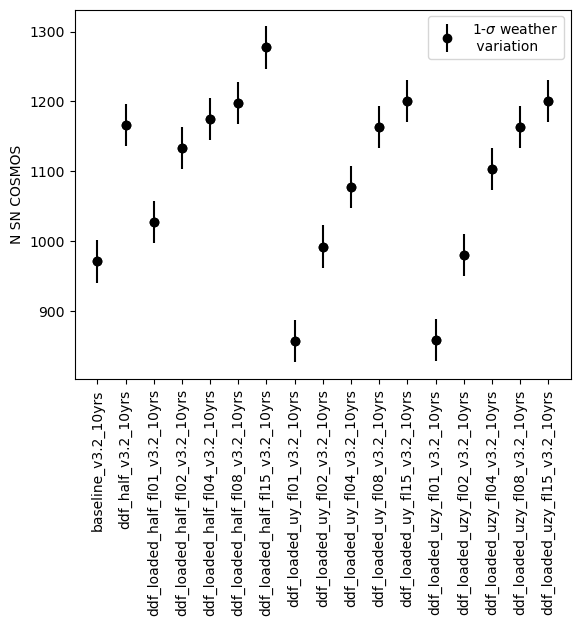

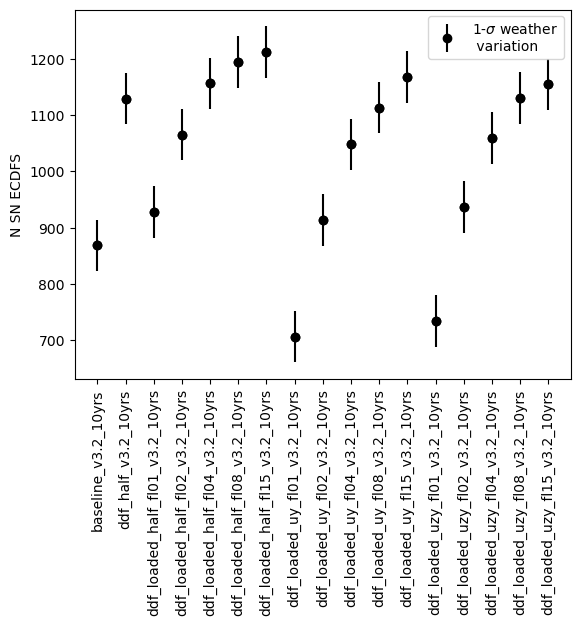

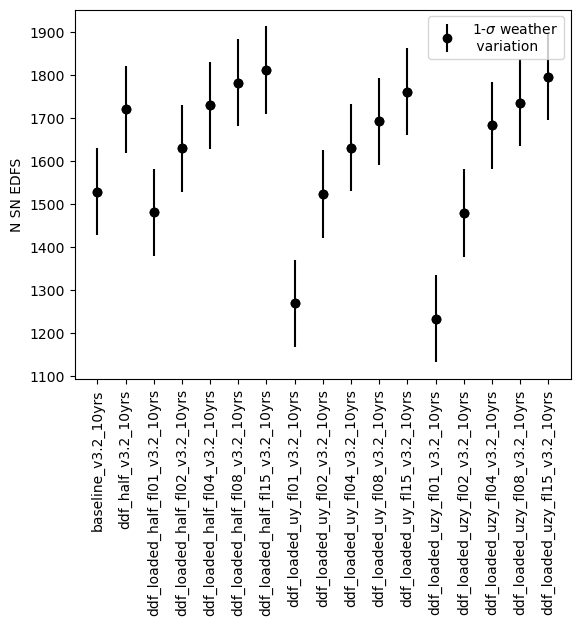

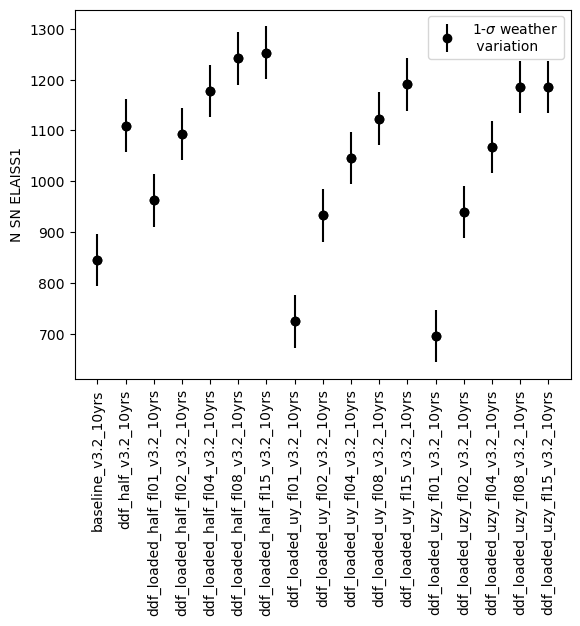

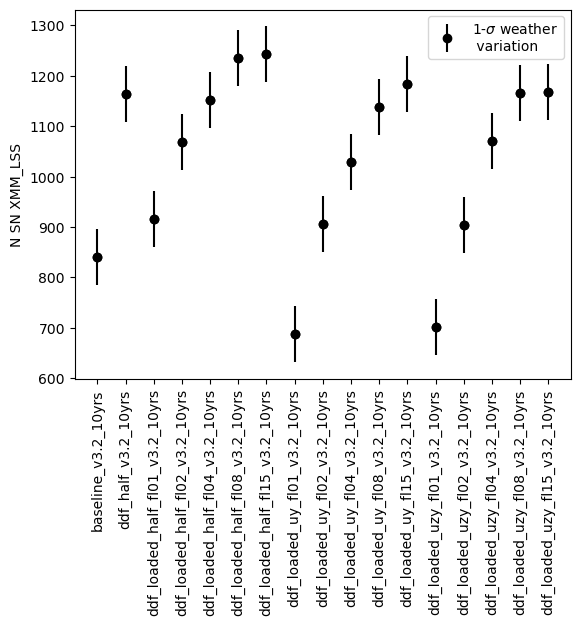

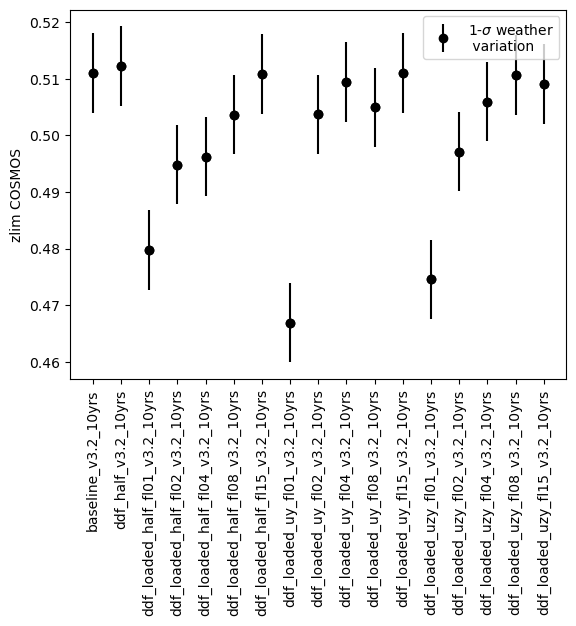

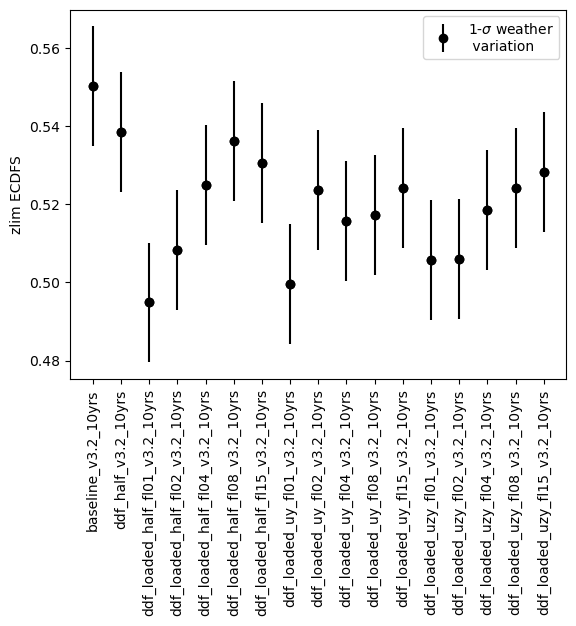

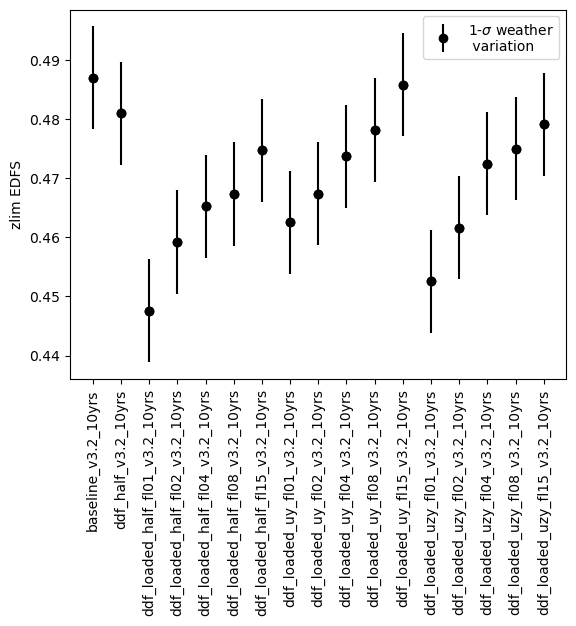

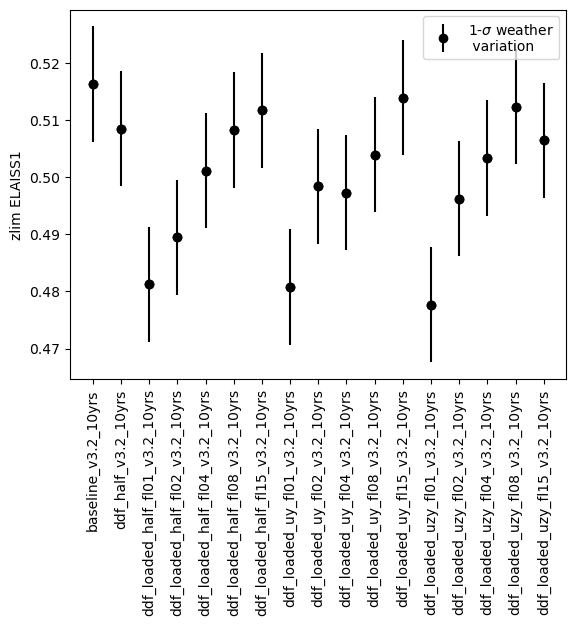

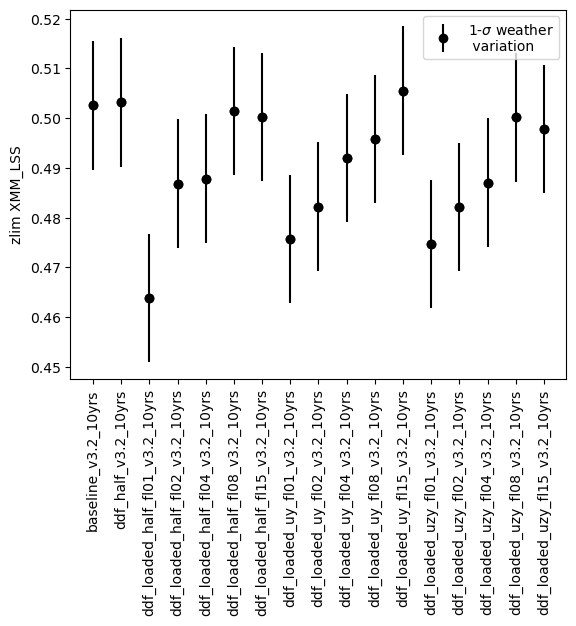

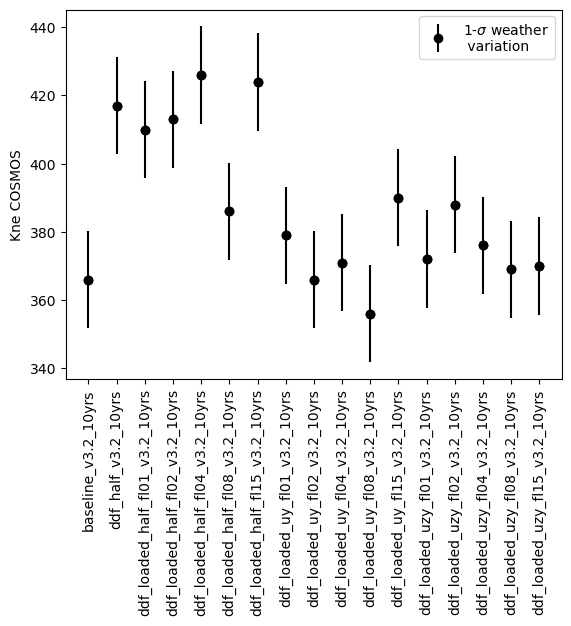

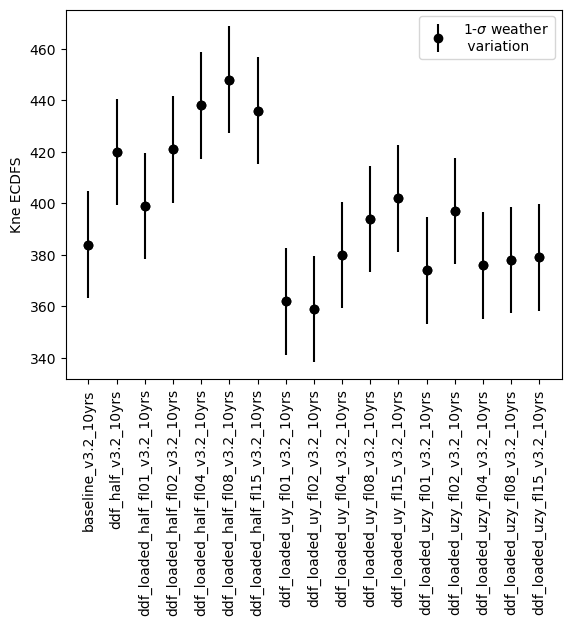

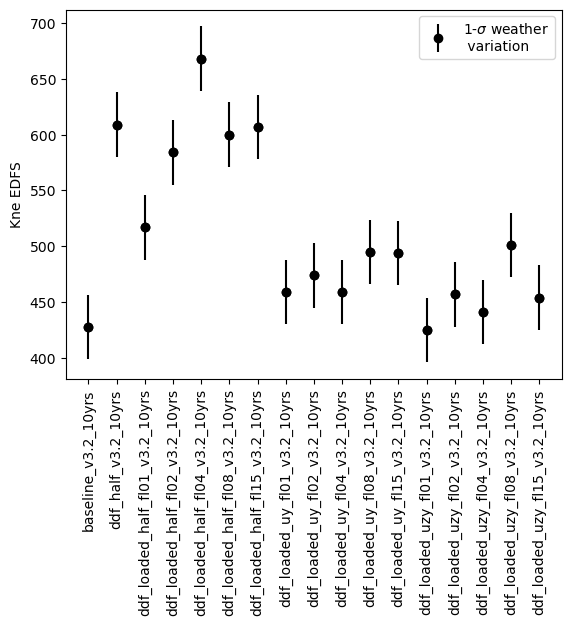

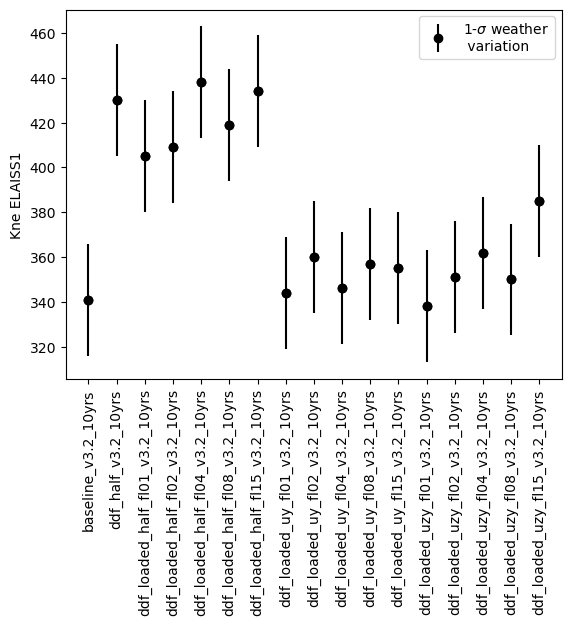

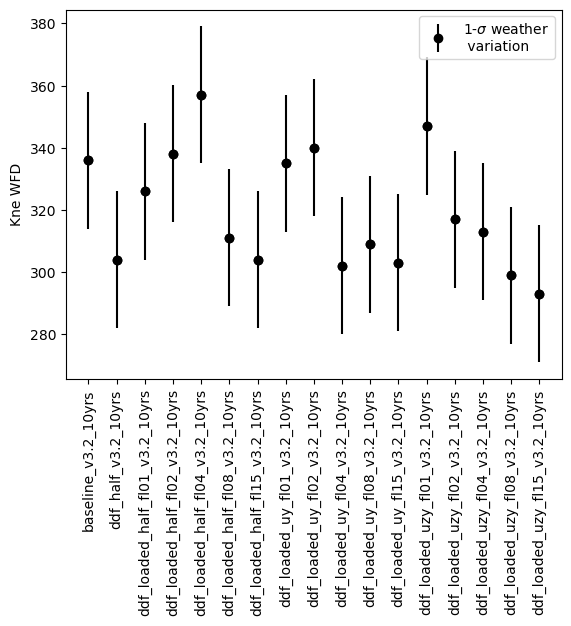

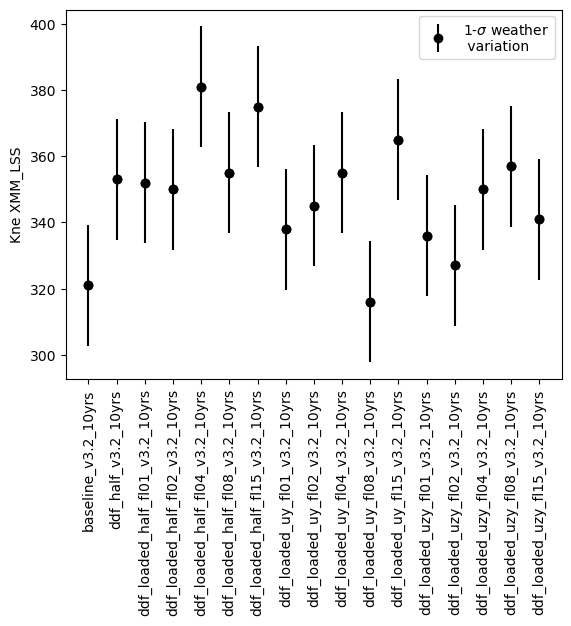

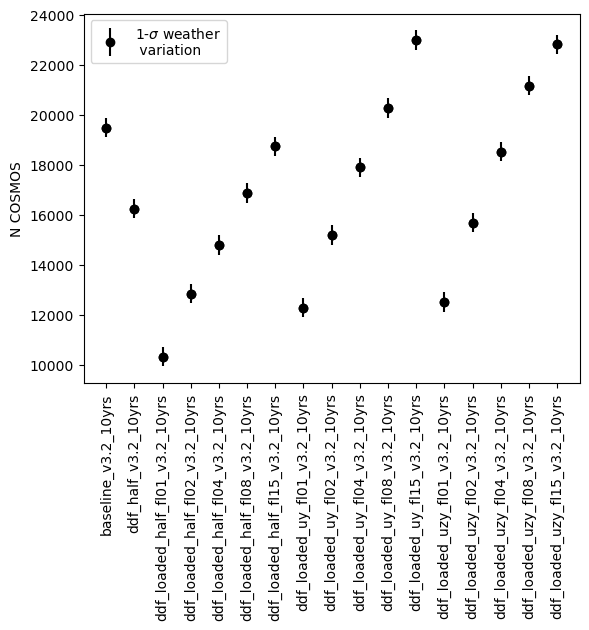

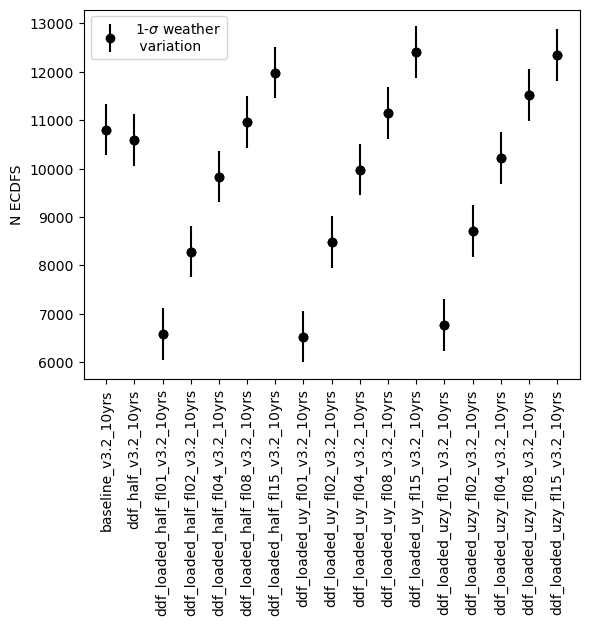

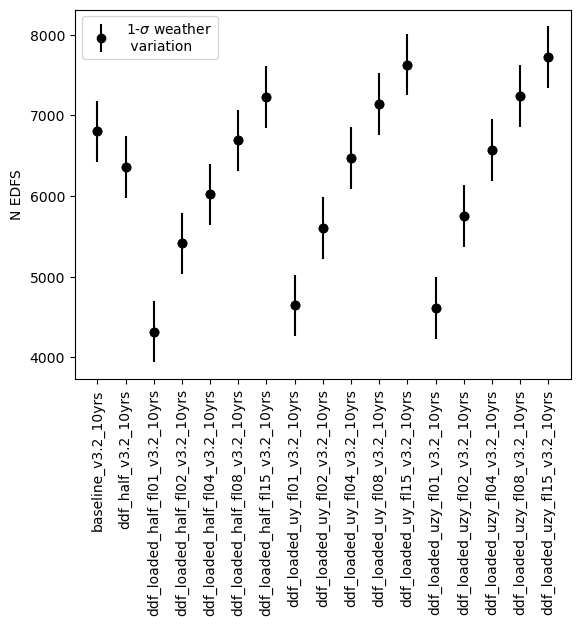

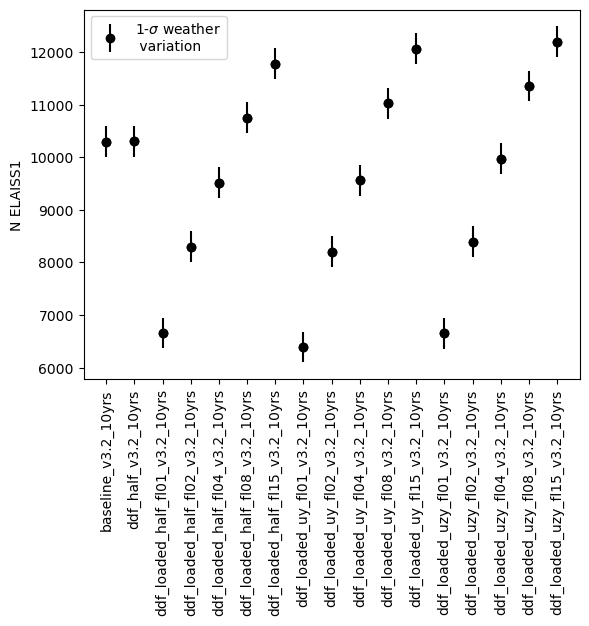

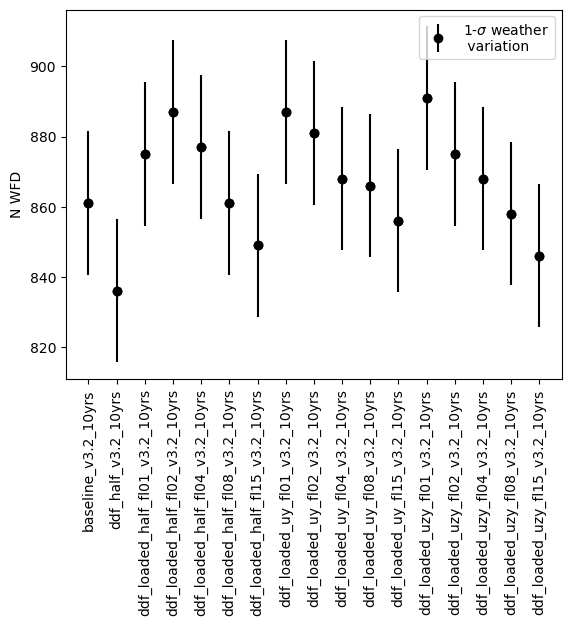

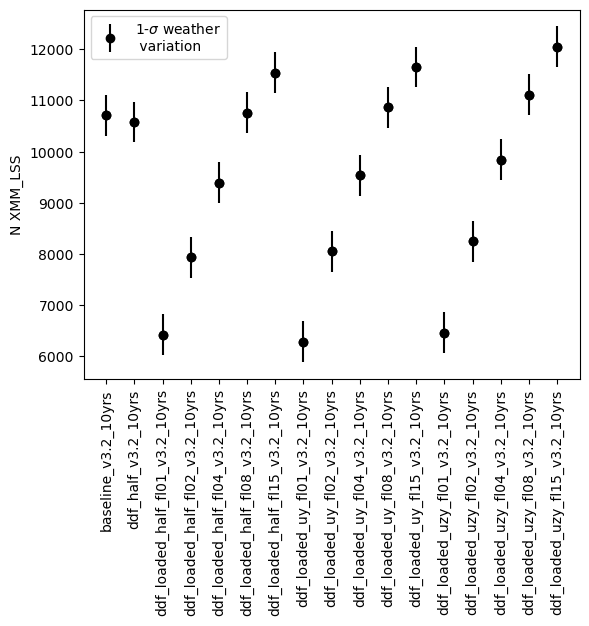

In [31]:
times = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run]

sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

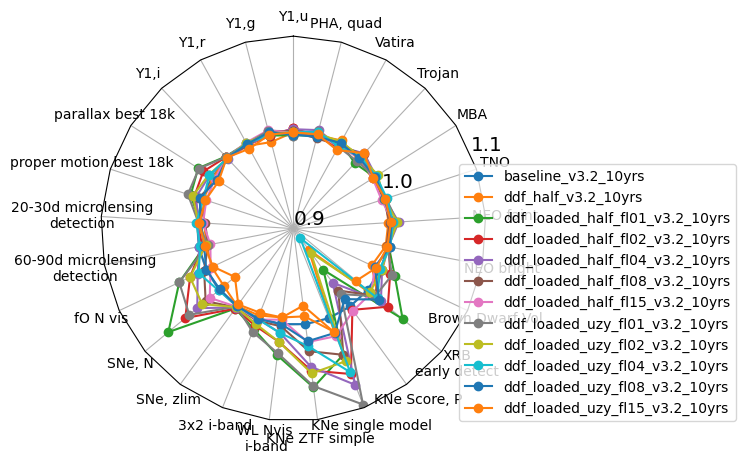

In [32]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run and 'uy' not in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

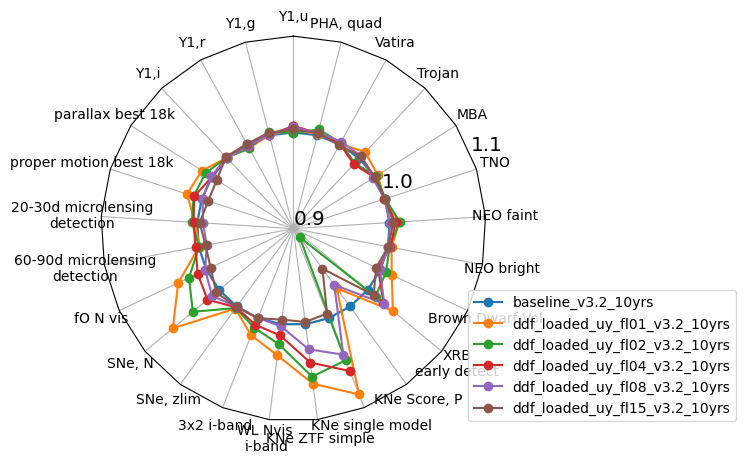

In [33]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run and 'uy' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

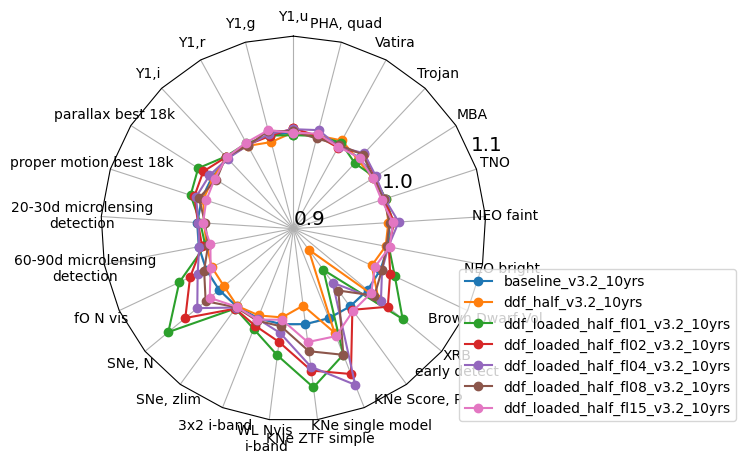

In [34]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'half'  in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

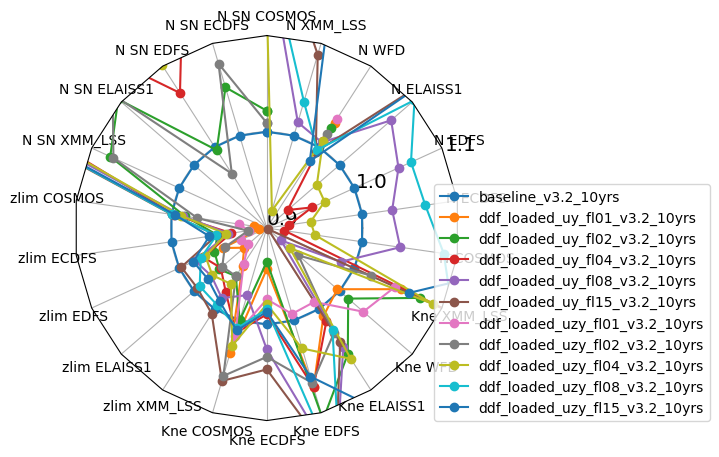

In [39]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [40]:
ndata

N SN COSMOS  N SN ECDFS  N SN EDFS  \
baseline_v3.2_10yrs                1.000000    1.000000   1.000000   
ddf_loaded_uy_fl01_v3.2_10yrs      0.882549    0.813745   0.829689   
ddf_loaded_uy_fl02_v3.2_10yrs      1.021863    1.052366   0.996227   
ddf_loaded_uy_fl04_v3.2_10yrs      1.109159    1.206371   1.066823   
ddf_loaded_uy_fl08_v3.2_10yrs      1.197569    1.281637   1.106796   
ddf_loaded_uy_fl15_v3.2_10yrs      1.236351    1.344548   1.151922   
ddf_loaded_uzy_fl01_v3.2_10yrs     0.884702    0.845678   0.806137   
ddf_loaded_uzy_fl02_v3.2_10yrs     1.009205    1.078062   0.967228   
ddf_loaded_uzy_fl04_v3.2_10yrs     1.136415    1.219884   1.100933   
ddf_loaded_uzy_fl08_v3.2_10yrs     1.197759    1.301587   1.135354   
ddf_loaded_uzy_fl15_v3.2_10yrs     1.236241    1.329237   1.175093   

                                N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
baseline_v3.2_10yrs                 1.000000      1.000000     1.000000   
ddf_loaded_uy_fl01_v3.2_10yrs       0.857742      0.817863     0.913790   
ddf_loaded_uy_fl02_v3.2_10yrs       1.104278      1.078816     0.985794   
ddf_loaded_uy_fl04_v3.2_10yrs       1.237655      1.223738     0.997032   
ddf_loaded_uy_fl08_v3.2_10yrs       1.329259      1.354723     0.988168   
ddf_loaded_uy_fl15_v3.2_10yrs       1.409296      1.407695     1.000015   
ddf_loaded_uzy_fl01_v3.2_10yrs      0.823172      0.834339     0.928715   
ddf_loaded_uzy_fl02_v3.2_10yrs      1.111861      1.075164     0.972899   
ddf_loaded_uzy_fl04_v3.2_10yrs      1.263787      1.274305     0.990206   
ddf_loaded_uzy_fl08_v3.2_10yrs      1.403082      1.387874     0.999311   
ddf_loaded_uzy_fl15_v3.2_10yrs      1.403548      1.389243     0.996198   

                                zlim ECDFS  zlim EDFS  zlim ELAISS1  \
baseline_v3.2_10yrs               1.000000   1.000000      1.000000   
ddf_loaded_uy_fl01_v3.2_10yrs     0.908191   0.949944      0.931179   
ddf_loaded_uy_fl02_v3.2_10yrs     0.951714   0.959772      0.965286   
ddf_loaded_uy_fl04_v3.2_10yrs     0.937311   0.972719      0.963186   
ddf_loaded_uy_fl08_v3.2_10yrs     0.940268   0.981918      0.976058   
ddf_loaded_uy_fl15_v3.2_10yrs     0.952567   0.997649      0.995344   
ddf_loaded_uzy_fl01_v3.2_10yrs    0.919112   0.929466      0.925172   
ddf_loaded_uzy_fl02_v3.2_10yrs    0.919610   0.948017      0.961169   
ddf_loaded_uzy_fl04_v3.2_10yrs    0.942448   0.970133      0.974871   
ddf_loaded_uzy_fl08_v3.2_10yrs    0.952819   0.975401      0.992261   
ddf_loaded_uzy_fl15_v3.2_10yrs    0.960270   0.983930      0.980885   

                                zlim XMM_LSS  ...  Kne EDFS  Kne ELAISS1  \
baseline_v3.2_10yrs                 1.000000  ...  1.000000     1.000000   
ddf_loaded_uy_fl01_v3.2_10yrs       0.946568  ...  1.072430     1.008798   
ddf_loaded_uy_fl02_v3.2_10yrs       0.959444  ...  1.107477     1.055718   
ddf_loaded_uy_fl04_v3.2_10yrs       0.978897  ...  1.072430     1.014663   
ddf_loaded_uy_fl08_v3.2_10yrs       0.986503  ...  1.156542     1.046921   
ddf_loaded_uy_fl15_v3.2_10yrs       1.005814  ...  1.154206     1.041056   
ddf_loaded_uzy_fl01_v3.2_10yrs      0.944577  ...  0.992991     0.991202   
ddf_loaded_uzy_fl02_v3.2_10yrs      0.959275  ...  1.067757     1.029326   
ddf_loaded_uzy_fl04_v3.2_10yrs      0.968998  ...  1.030374     1.061584   
ddf_loaded_uzy_fl08_v3.2_10yrs      0.995228  ...  1.170561     1.026393   
ddf_loaded_uzy_fl15_v3.2_10yrs      0.990543  ...  1.060748     1.129032   

                                 Kne WFD  Kne XMM_LSS  N COSMOS   N ECDFS  \
baseline_v3.2_10yrs             1.000000     1.000000  1.000000  1.000000   
ddf_loaded_uy_fl01_v3.2_10yrs   0.997024     1.052960  0.630934  0.604451   
ddf_loaded_uy_fl02_v3.2_10yrs   1.011905     1.074766  0.779345  0.785222   
ddf_loaded_uy_fl04_v3.2_10yrs   0.898810     1.105919  0.918293  0.923611   
ddf_loaded_uy_fl08_v3.2_10yrs   0.919643     0.984424  1.039982  1.031601   
ddf_loaded_uy_fl15_v3.2_10yrs   0.901786     1.137072  1.17954